In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cmasher as cmr
cmap=cmr.sunburst_r
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
data = at.Table.read("/Users/Tavangar/Work/gd1-dr3/data/GD1-region-alldata.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

# run_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask)]
# bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
# stream_data_ = iso_obj.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask]

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.26720538330726), np.float64(-3.1634227867925135), np.float64(0.5151487185597746), np.float64(0.38624247171130377)] 

Producing the polygon and mask


/Users/Tavangar/Work/stream-membership/stream-env/lib/python3.12/site-packages/cats/CMD.py:293: RuntimeWarning: invalid value encountered in divide
  signal = signal / signal_counts


In [112]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [113]:
only_rv_run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

# Fill in rv data for rows without it (rv=0, rv_err=1e4)
run_data_['rv'][run_data_['rv'].mask] = 0
run_data_['rv_err'][run_data_['rv_err'].mask] = 1e4

bkg_data_['rv'][bkg_data_['rv'].mask] = 0
bkg_data_['rv_err'][bkg_data_['rv_err'].mask] = 1e4

stream_data_['rv'][stream_data_['rv'].mask] = 0
stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

In [6]:
print(len(run_data_))
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
run_data_err = {'pm1': jnp.array(run_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(run_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(run_data_['rv_err'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

83735


In [7]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)

In [27]:
bkg_knot_spacings    = jnp.array([40,40,40,40])
stream_knot_spacings = jnp.array([5,10,10,10,10])
offtrack_dx          = jnp.array([1.5,0.75])

In [250]:
specifications = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings, offtrack_dx])

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
# filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)
filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}_off{}_{}_logits_all_footprint.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
svi_results = full_dict['svi_results']
guide = full_dict['guide']

mm = guide.model

In [251]:
svi_results.params['mixture-probs_auto_loc']

Array([4.8068305 , 2.97212253], dtype=float64)

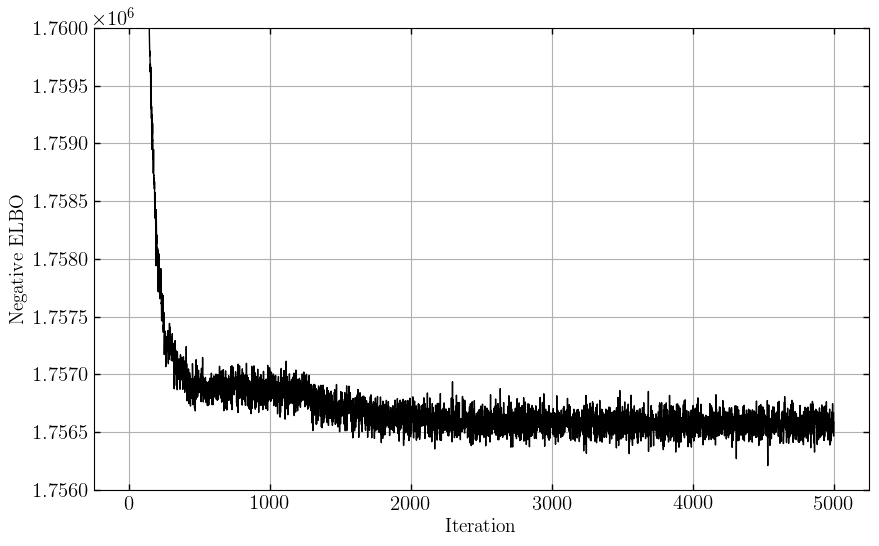

In [252]:
plt.figure(figsize=(10,6))
plt.plot(svi_results.losses, lw=1)
# plt.xscale('log')
plt.ylim(1.756e6, 1.76e6)
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

In [253]:
MAP_p_expanded = get_svi_params(mm, run_data, svi_results, guide, num_samples=100, key=jax.random.PRNGKey(42))

In [254]:
pred_dist = Predictive(guide, params=svi_results.params, num_samples=100)
pars_ = pred_dist(jax.random.PRNGKey(42), data=run_data)

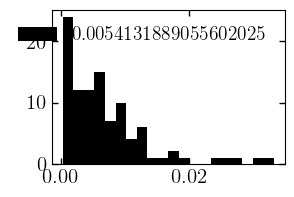

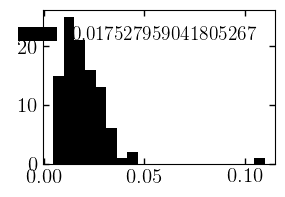

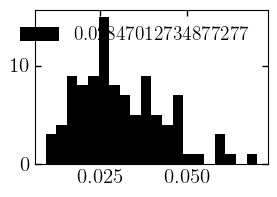

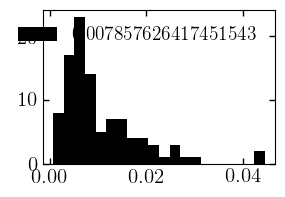

In [36]:
for i in range(219):
    if jnp.median(pars_['offtrack:phi1-phi2:mixing_distribution'][:,i]) > 0.005:
        plt.figure(figsize=(3,2))
        plt.hist(pars_['offtrack:phi1-phi2:mixing_distribution'][:,i], bins=20, 
                 label=jnp.median(pars_['offtrack:phi1-phi2:mixing_distribution'][:,i]))
        plt.legend()
        plt.show()

(-100.0, 20.0)

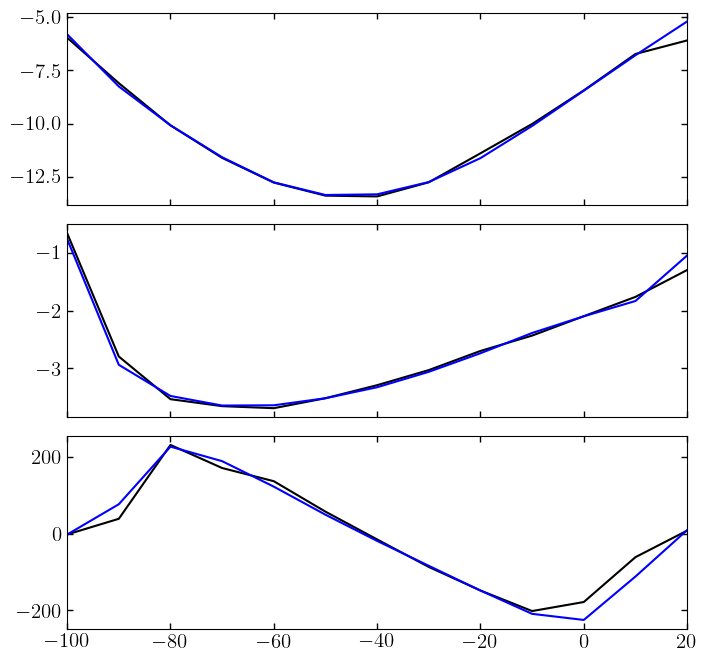

In [255]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(8,8), sharex=True)
ax1.plot(stream_model.coord_parameters['pm1']['knots'], MAP_p_expanded['offtrack']['pm1']['loc_vals'])
ax1.plot(stream_model.coord_parameters['pm1']['knots'], MAP_p_expanded['stream']['pm1']['loc_vals'])

ax2.plot(stream_model.coord_parameters['pm2']['knots'], MAP_p_expanded['offtrack']['pm2']['loc_vals'])
ax2.plot(stream_model.coord_parameters['pm2']['knots'], MAP_p_expanded['stream']['pm2']['loc_vals'])

ax3.plot(stream_model.coord_parameters['rv']['knots'], MAP_p_expanded['offtrack']['rv']['loc_vals'])
ax3.plot(stream_model.coord_parameters['rv']['knots'], MAP_p_expanded['stream']['rv']['loc_vals'])
ax3.set_xlim(-100,20)

In [256]:
MAP_p_expanded['stream']['rv']

{'loc_vals': Array([  -2.23474001,   76.85316678,  227.02244614,  189.1720425 ,
         122.72209372,   49.55453393,  -18.81976912,  -83.7402812 ,
        -148.23413252, -209.00437409, -224.88520307, -111.66167846,
           9.44146741], dtype=float64),
 'scale_vals': Array([ 7.25155343, 18.77274972, 23.45388835, 17.95447984, 15.24535496,
        11.8057182 ,  7.99983413,  4.07708706,  3.53879023,  8.38014217,
        18.28238479, 30.31963757,  6.33701805], dtype=float64)}

In [257]:
print(MAP_p_expanded['mixture-probs'])

[9.83925623e-01 1.52454263e-02 7.86889867e-04]


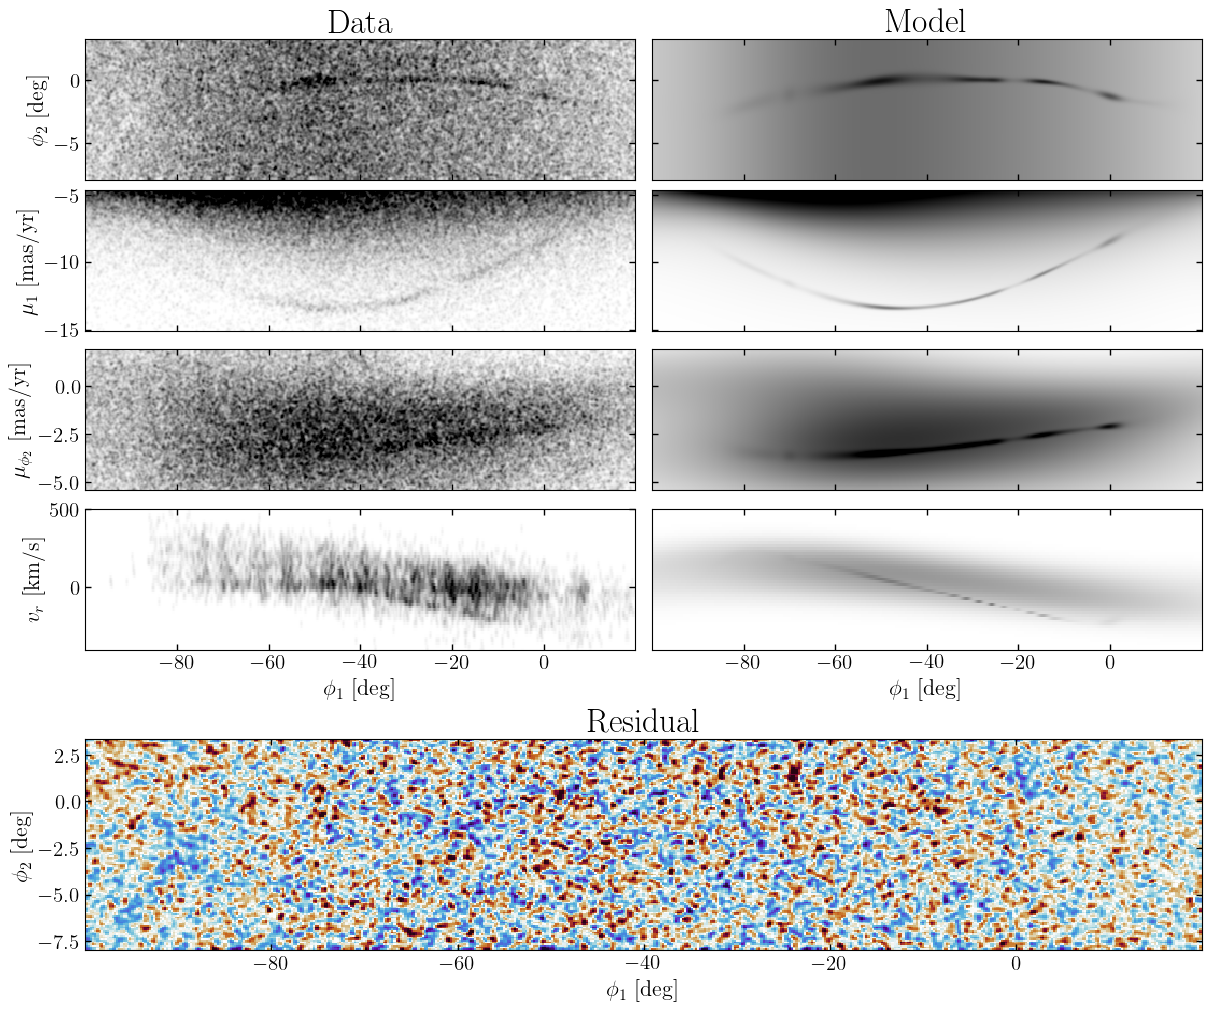

In [394]:
cmap='gray_r'
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_run_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=MAP_p_expanded, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_['rv'][run_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=MAP_p_expanded, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=MAP_p_expanded, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)



plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

In [324]:
grids1, ln_ps1 = mm['stream'].evaluate_on_2d_grids(MAP_p_expanded['stream'], grids=plot_grids, grid_coord_names=[('phi1', 'phi2')])
grids2, ln_ps2 = mm['background'].evaluate_on_2d_grids(MAP_p_expanded['background'], grids=plot_grids, grid_coord_names=[('phi1', 'phi2')])

In [325]:
np.sum(np.exp(ln_ps2[('phi1', 'phi2')]))

np.float64(47.79114349486608)

In [322]:
np.sum(np.exp(ln_ps1[('phi1', 'phi2')]))

np.float64(47.79113191353931)

In [323]:
np.sum(np.exp(ln_ps[('phi1', 'phi2')]))

np.float64(47.793028685441705)

In [326]:
out2 = len(run_data_)*MAP_p_expanded["mixture-probs"][0] * np.exp(ln_ps2[('phi1','phi2')]) * bin_area
out1 = len(run_data_)*MAP_p_expanded["mixture-probs"][1] * np.exp(ln_ps1[('phi1','phi2')]) * bin_area
out = len(run_data_)*MAP_p_expanded["mixture-probs"][2] * np.exp(ln_ps[('phi1','phi2')]) * bin_area

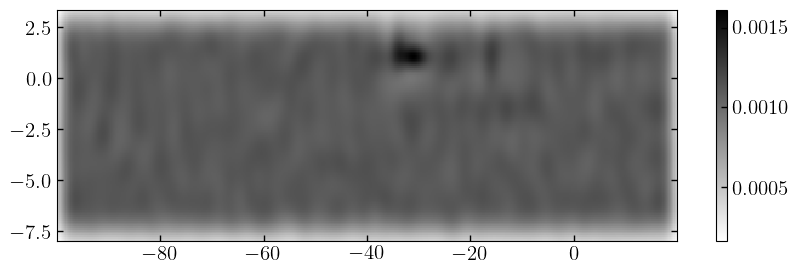

In [327]:
plt.figure(figsize=(10,3))
plt.pcolormesh(grids[('phi1','phi2')][0],grids[('phi1','phi2')][1] , out, cmap='gray_r')
plt.colorbar()
plt.show()

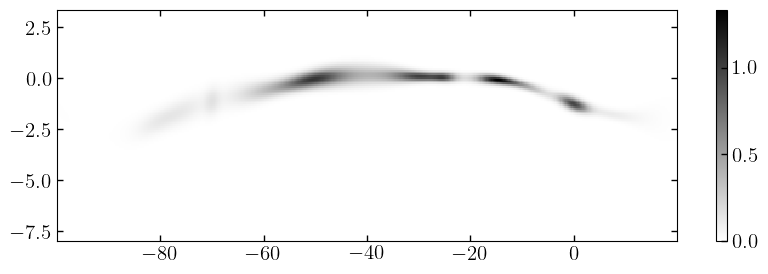

In [329]:
plt.figure(figsize=(10,3))
plt.pcolormesh(grids[('phi1','phi2')][0],grids[('phi1','phi2')][1] , out1, cmap='gray_r')
plt.colorbar()
plt.show()

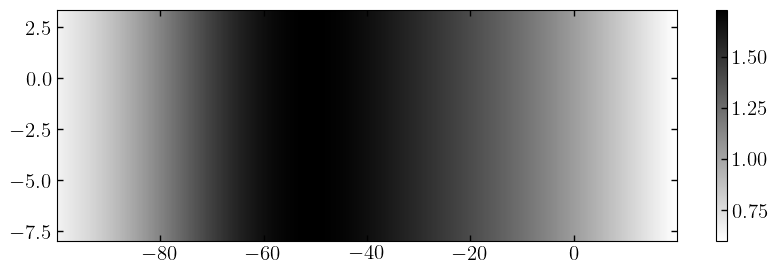

In [330]:
plt.figure(figsize=(10,3))
plt.pcolormesh(grids[('phi1','phi2')][0],grids[('phi1','phi2')][1] , out2, cmap='gray_r')
plt.colorbar()
plt.show()

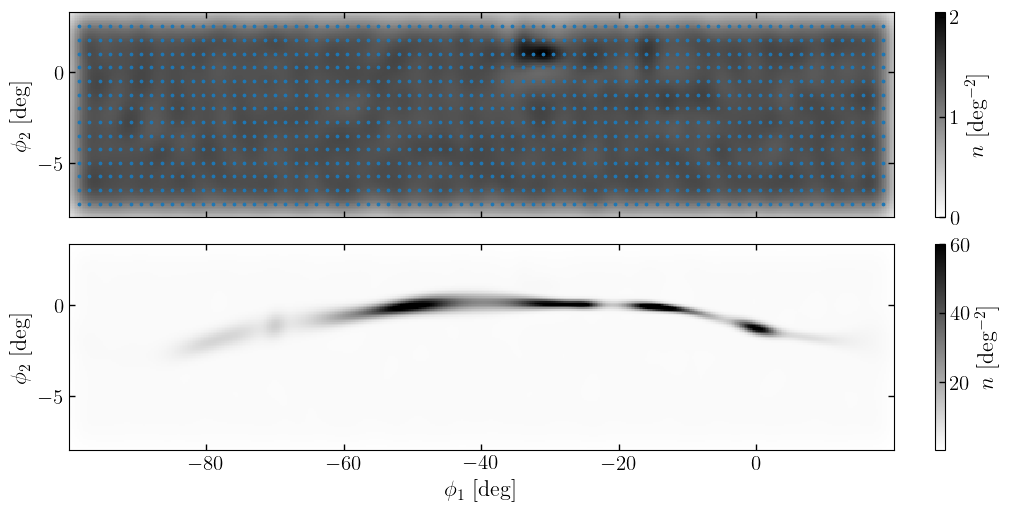

In [261]:
str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[mm['stream'], mm['offtrack']],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
    )

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = MAP_p_expanded["mixture-probs"][1:] / jnp.sum(MAP_p_expanded["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

bin_area = jnp.diff(plot_grids['phi1'])[0] * jnp.diff(plot_grids['phi2'])[0]

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_), 
                                                    grids=plot_grids, pars=MAP_p_expanded['offtrack'], grid_coord_names=[('phi1', 'phi2')], 
                                                    axes=ax1, pcolormesh_kwargs=dict(rasterized=True, cmap=cmap, vmin=0))
ax1.scatter(mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][0], 
            mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][1], color="tab:blue", s=3)
cbar1 = fig.colorbar(pcms1[0], ax=ax1)#, ticks=jnp.array([0, 0.2, .4, .6, .8])*bin_area, pad=0.02,
           # format=mticker.FixedFormatter(['0', '0.2', '0.4', '0.6', '0.8']))

# _, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_) * jnp.sum(MAP_p_expanded["mixture-probs"][1:]),
#                                                 pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
#                                                 pcolormesh_kwargs=dict(rasterized=True, vmax=0.9, vmin=0, cmap=cmap))
# cbar2 = fig.colorbar(pcms2[0], ax=ax2, ticks=jnp.array([0, 10, 20, 30, 40, 50])*bin_area, pad=0.02,
#            format=mticker.FixedFormatter(['0', '10', '20', '30', '40', '50']), extend='max')

_, _, pcms2 = mm['stream'].plot_model_projections(ndata=len(run_data_),
                                                pars=MAP_p_expanded['stream'], grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, cmap=cmap))
im2 = plt.pcolormesh(plot_grids['phi1'], plot_grids['phi2'], pcms2[0].get_array()+pcms1[0].get_array(), 
                     rasterized=True, cmap=cmap, vmax=60)
cbar2 = fig.colorbar(im2, ax=ax2)




ax1.set_xlabel("")
cbar1.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)


plt.savefig('../../paper_figures/offtrack_model.pdf')
plt.savefig('../../paper_figures/offtrack_model.png')
plt.show()

In [228]:
pcms2[0].get_array().shape

(127, 511)

### Make Linear Density Plot

In [335]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = MAP_p_expanded['stream']
offtrack_params = MAP_p_expanded['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [336]:
str_bkg_specs = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings])
# no_off_filename = svi_results_dir + 'mm_bkg{}_{}_{}_stream{}_{}_{}_{}.pkl'.format(*str_bkg_specs)
no_off_filename = svi_results_dir + 'mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}.pkl'.format(*str_bkg_specs)

with open(no_off_filename, 'rb') as input_file_:
    no_off_full_dict = pickle.load(input_file_)
    
no_off_MAP_svi_results = no_off_full_dict['svi_results']
no_off_guide = no_off_full_dict['guide']

str_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[bkg_model, stream_model],
)

pred_dist0 = Predictive(no_off_guide, params=no_off_MAP_svi_results.params, num_samples=100)
no_off_MAP_p_ = pred_dist0(jax.random.PRNGKey(42), data=run_data)
no_off_MAP_p = {k: jnp.median(v, axis=0) for k, v in no_off_MAP_p_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
MAP_p_no_off_expanded = str_bkg_mm.expand_numpyro_params(no_off_MAP_p)

In [337]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
ndata = len(run_data_)
stream_lin_dens = ndata*MAP_p_expanded['mixture-probs'][1] * jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * (phi1s[1]-phi1s[0])
off_lin_dens = ndata*MAP_p_expanded['mixture-probs'][2] * jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * (phi1s[1]-phi1s[0])


phi2_track = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['scale_vals'])

stream_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['loc_vals'])
stream_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['scale_vals'])
stream_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
stream_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['scale_vals'])
stream_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
stream_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['scale_vals'])

offtrack_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['loc_vals'])
offtrack_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['scale_vals'])
offtrack_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['loc_vals'])
offtrack_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['scale_vals'])
offtrack_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['loc_vals'])
offtrack_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['scale_vals'])

phi2_width_no_off = IUS(stream_opt.coord_parameters['phi2']['knots'], MAP_p_no_off_expanded['stream']['phi2']['scale_vals'])

In [338]:
import astropy.coordinates as coord
import gala.coordinates as gc

m67_gd1_coord = coord.SkyCoord(ra="8h51m17s", dec="+11d48m0s", frame=coord.ICRS).transform_to(gc.GD1Koposov10)

In [339]:
#Ibata+20 predicts and Ibata+24 plots convinvingly (Figure 22) epicyclic density peaks every 2.64 kpc. 
#  Using this does not line up with the peaks in panel 1 below. 
#  However, if our distance track is low by 0.8 kpc consistently (unlikely) or if the epicyclic overdensities are instead 2.42 kpc apart, we get excellent agreement with the observed peaks

## Idea: place a vertical line at the highest density place
initial_phi1 = phi1s[np.argmax(stream_lin_dens)]
epi_sep = 2.4

# Define the distance modulus relation and correct distance in kpc
def distance_modulus(phi1):
    return 0.000244 * phi1**2 + 0.0244 * phi1 + 14.980

def distance_kpc(phi1):
    m_minus_M = distance_modulus(phi1)
    return 10**((m_minus_M + 5) / 5) / 1000 #+0.8

# Define the grid for phi1 and calculate distances
distances_kpc = distance_kpc(phi1s)  # Compute distances in kpc

# Compute arc length increments and cumulative arc length
distances_gradient = np.gradient(distances_kpc, phi1s) * (np.pi / 180)  # Gradient in radians
arc_length_increment = distances_kpc * np.sqrt(1 + distances_gradient**2) * np.gradient(phi1s) * np.pi / 180
cumulative_arc_length = np.cumsum(arc_length_increment)

# Interpolate cumulative arc length to phi1
from scipy.interpolate import interp1d
arc_length_interp = interp1d(cumulative_arc_length, phi1s, kind="linear", fill_value="extrapolate")

initial_arc_length = np.interp(initial_phi1, phi1s, cumulative_arc_length)

# Compute arc lengths for density peaks, both forward and backward
density_peak_arc_lengths = [initial_arc_length]
while density_peak_arc_lengths[-1] + epi_sep < cumulative_arc_length[-1]:
    density_peak_arc_lengths.append(density_peak_arc_lengths[-1] + epi_sep)

while density_peak_arc_lengths[0] - epi_sep > cumulative_arc_length[0]:
    density_peak_arc_lengths.insert(0, density_peak_arc_lengths[0] - epi_sep)

# Map arc lengths to phi1 positions
density_peaks_phi1 = arc_length_interp(density_peak_arc_lengths)
print(density_peaks_phi1)

[-99.76025128 -84.7495244  -67.7821578  -49.61132302 -31.47727426
 -14.60375577   0.28949731  13.04873911]


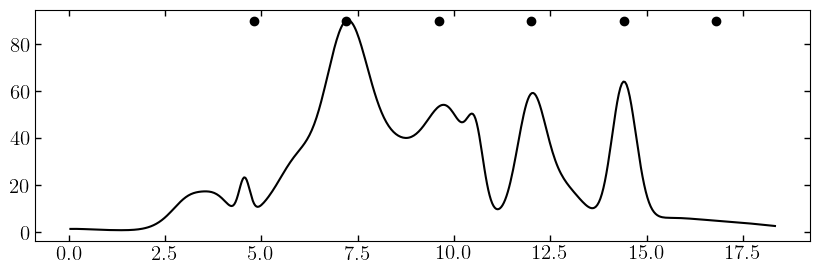

In [340]:
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(arc_length_increment), stream_lin_dens)
plt.scatter(jnp.array([5,7.4, 9.8,12.2,14.6,17])-0.2,jnp.array([90,90,90,90,90,90]))
plt.show()

In [341]:
physical_scale_spline = IUS(np.cumsum(arc_length_increment), stream_lin_dens, k=3)
xs = np.linspace(0,18.3,10000)
stream_physical_scale_dens = physical_scale_spline(xs)

def calculate_power_spectrum(x, y):
    """
    Calculate the power spectrum of a given curve defined by x and y values.

    Parameters:
        x (array-like): The x-values of the curve (e.g., time or spatial coordinates).
        y (array-like): The y-values of the curve (e.g., density or intensity).

    Returns:
        frequencies (ndarray): The frequencies corresponding to the power spectrum.
        power_spectrum (ndarray): The power spectrum values.
    """
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute the sampling interval (assumes uniform spacing)
    dx = np.mean(np.diff(x))

    # Perform the Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(y)

    # Compute the frequencies
    frequencies = np.fft.fftfreq(len(y), d=dx)

    # Compute the power spectrum (magnitude squared of FFT)
    power_spectrum = np.abs(fft_result)**2

    # Return only the positive frequencies and corresponding power spectrum
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_power_spectrum = power_spectrum[:len(power_spectrum)//2]

    return positive_frequencies, positive_power_spectrum

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_78742/1117561592.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.linspace(1,7,1000), IUS(np.flip(1/frequencies)[4980:-1], np.flip(power_spectrum[1:-4980]),k=3)(np.linspace(1,7,1000)))


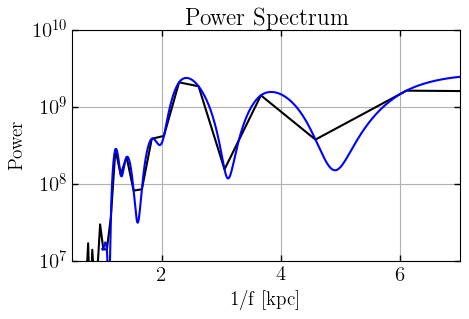

In [342]:
frequencies, power_spectrum = calculate_power_spectrum(xs, stream_physical_scale_dens)

# Plot the power spectrum
plt.figure(figsize=(5, 3))
plt.semilogy(1/frequencies[1:], power_spectrum[1:])
plt.plot(np.linspace(1,7,1000), IUS(np.flip(1/frequencies)[4980:-1], np.flip(power_spectrum[1:-4980]),k=3)(np.linspace(1,7,1000)))
plt.xlim(0.5, 7)
plt.ylim(1e7,1e10)
plt.title('Power Spectrum')
plt.xlabel('1/f [kpc]')
plt.ylabel('Power')
plt.grid()
plt.show()

In [343]:
import scipy
scipy.optimize.minimize_scalar(IUS(np.flip(1/frequencies)[4980:-1], -np.flip(power_spectrum[1:-4980]),k=3), bounds=[2,3], method='bounded')

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_78742/278320560.py:2: RuntimeWarning: divide by zero encountered in divide
  scipy.optimize.minimize_scalar(IUS(np.flip(1/frequencies)[4980:-1], -np.flip(power_spectrum[1:-4980]),k=3), bounds=[2,3], method='bounded')


 message: Solution found.
 success: True
  status: 0
     fun: -2368114446.2490497
       x: 2.4107208622555523
     nit: 10
    nfev: 10

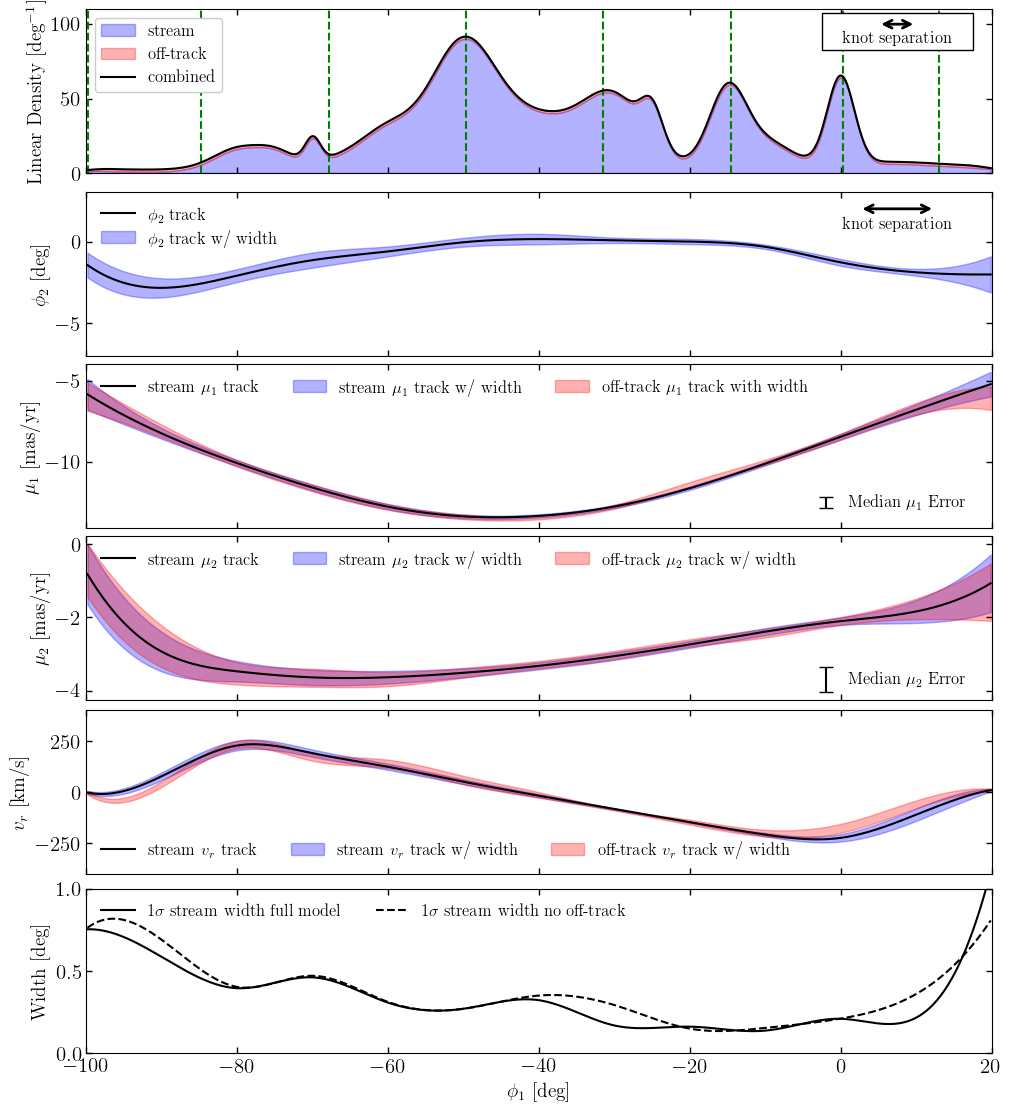

In [395]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='r', alpha=0.3, label=r'off-track')
for peak in density_peaks_phi1:
    ax1.axvline(peak, color='g', ls='--')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'combined')
ax1.annotate("", xy=(10,100), xytext=(10-stream_knot_spacings[0],100), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
magic_box1 = mpl.patches.Rectangle((7.5 - 20 / 2, 95 - 25 / 2), 20, 25, facecolor="white", edgecolor="black", linewidth=1, zorder=2)
ax1.add_patch(magic_box1)
ax1.text(10-0.5*stream_knot_spacings[0], 90, "knot separation", fontsize=12, ha="center", va="center")
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,110)
ax1.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, framealpha=1)

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'$\phi_2$ track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='b', alpha=0.3, label=r'$\phi_2$ track w/ width')
ax2.annotate("", xy=(12.5,2), xytext=(12.5-stream_knot_spacings[1],2), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
ax2.text(12.5-0.5*stream_knot_spacings[1], 1, "knot separation", fontsize=12, ha="center", va="center")
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, stream_pm1_track(phi1s), c='k', label=r'stream $\mu_1$ track')
ax3.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax3.text(1, -12.8, r'Median $\mu_1$ Error', fontsize=12)
ax3.fill_between(phi1s, stream_pm1_track(phi1s) - stream_pm1_width(phi1s), stream_pm1_track(phi1s) + stream_pm1_width(phi1s), 
                 color='b', alpha=0.3, label=r'stream $\mu_1$ track w/ width')
ax3.fill_between(phi1s, offtrack_pm1_track(phi1s) - offtrack_pm1_width(phi1s), offtrack_pm1_track(phi1s) + offtrack_pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'off-track $\mu_1$ track with width')
ax3.set_ylabel(r'$\mu_1$ [mas/yr]', fontsize=14)
# ax3.set_ylim(-18,-4)
ax3.legend(fontsize=12, loc='upper left', ncol=3)

ax4.plot(phi1s, stream_pm2_track(phi1s), c='k', label=r'stream $\mu_2$ track')
ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -3.8, r'Median $\mu_2$ Error', fontsize=12)
ax4.fill_between(phi1s, stream_pm2_track(phi1s) - stream_pm2_width(phi1s), stream_pm2_track(phi1s) + stream_pm2_width(phi1s), 
                 color='b', alpha=0.3, label=r'stream $\mu_2$ track w/ width')
ax4.fill_between(phi1s, offtrack_pm2_track(phi1s) - offtrack_pm2_width(phi1s), offtrack_pm2_track(phi1s) + offtrack_pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'off-track $\mu_2$ track w/ width')
ax4.set_ylabel(r'$\mu_2$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left', ncol=3)

ax5.plot(phi1s, stream_rv_track(phi1s), c='k', label=r'stream $v_r$ track')
# ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, stream_rv_track(phi1s) - stream_rv_width(phi1s), stream_rv_track(phi1s) + stream_rv_width(phi1s), 
                 color='b', alpha=0.3, label=r'stream $v_r$ track w/ width')
ax5.fill_between(phi1s, offtrack_rv_track(phi1s) - offtrack_rv_width(phi1s), offtrack_rv_track(phi1s) + offtrack_rv_width(phi1s), 
                 color='r', alpha=0.3, label=r'off-track $v_r$ track w/ width')
ax5.set_ylabel(r'$v_r$ [km/s]', fontsize=14)
ax5.set_ylim(-400,400)
ax5.legend(fontsize=12, loc='lower left', ncol=3)

ax6.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
ax6.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no off-track')
ax6.set_ylim(0, 1)
ax6.set_ylabel(r'Width [deg]', fontsize=14)
ax6.legend(fontsize=12, loc='upper left', ncol=2)

ax6.set_xlim(-100, 20)
ax6.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

plt.savefig('../../paper_figures/stream_properties.png')
plt.savefig('../../paper_figures/stream_properties.pdf')
plt.show()

In [345]:
print(jnp.median(stream_lin_dens[(phi1s<5) & (phi1s>-65)]))
print(jnp.median(stream_lin_dens[((phi1s>5) | (phi1s<-65))&(phi1s>-90)]))

43.24338840349512
6.404825566577737


In [245]:
jnp.median(stream_lin_dens[(phi1s<5) & (phi1s>-65)]) / jnp.median(stream_lin_dens[((phi1s>5) | (phi1s<-65))&(phi1s>-90)])

Array(6.78359882, dtype=float64)

In [346]:
all_data_ = iso_obj.cat[pm_mask]
all_data_['rv'][all_data_['rv'].mask] = 0
all_data_['rv_err'][all_data_['rv_err'].mask] = 1e4

all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}
all_data_err = {'phi1': 1e-4, 'phi2': 1e-4,
                'pm1': jnp.array(all_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(all_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(all_data_['rv_err'], dtype="f8"),}

In [347]:
## membership probability calculation

lp_dict = {} # create dictionary of log probabilities for each component

for n_comp, component in enumerate(mm.components):
    print(component.name) #background, stream, or offtrack

    ## Get distributions for every coordinate in the component
    dists = component.make_dists(MAP_p_expanded[component.name])

    ## Create empty array of log probabilities for each data point and coordinate
    component_lp_stack = jnp.empty((len(dists), len(all_data_)))

    for i, (coord_name, dist_) in enumerate(dists.items()):
        if isinstance(coord_name, tuple): # (phi1, phi2) offtrack
            _data = jnp.stack([all_data[k] for k in coord_name], axis=-1)
            _errors = jnp.stack([all_data_err[k] for k in coord_name], axis=-1)   # Include errors
        else:
            _data = jnp.asarray(all_data[coord_name])
            _errors = jnp.asarray(all_data_err[coord_name])  # Include errors
        
        if isinstance(dist_, (IndependentGMM, dist.Uniform)):
            # IndependentGMM is only used for position space at the moment so ignoring errors is fine
            variable_lp  = dist_.log_prob(value=_data)
            
        elif isinstance(dist_, TruncatedNormalSpline): # One truncated spline
            # Get the spline mean and scale at every data point's phi1
            #  the scale should the the rms of the model scale and the error on that point
            spline_mean = dist_._loc_spl(all_data['phi1'])
            adjusted_spline_scale = jnp.sqrt(dist_._scale_spl(all_data['phi1'])**2 + _errors**2)

            # Get lower and upper bounds of truncated normal (in terms of number of stds from mean)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale
            
            # Create a truncated normal per data point
            variable_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data, 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )
        elif isinstance(dist_, TruncatedNormal1DSplineMixture): # mixture of truncated splines
            # Similar to above
            #  Create the mean and scale at each data point's 'phi1' for each of the truncated splines (shape (K, len(data)))
            spline_mean = jnp.stack([dist_._component_distributions[i]._loc_spl(all_data['phi1']) for i in range(dist_._n_components)])
            spline_scale = jnp.stack([dist_._component_distributions[i]._scale_spl(all_data['phi1']) for i in range(dist_._n_components)])
            adjusted_spline_scale = jnp.sqrt(spline_scale**2 + _errors**2)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale

            component_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data[None, :], 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )            
            # Including the weights (is this right?)
            mixture_weights = MAP_p_expanded[component.name][coord_name]['mixing_distribution']
            weighted_comp_lp = component_lp + jnp.log(mixture_weights)[:, None]

            variable_lp = jax.scipy.special.logsumexp(weighted_comp_lp, axis=0)
            
        else: # shouldn't be used but is here just in case
            variable_lp = dist_.log_prob(value=_data, x=jnp.asarray(all_data['phi1']))

        # add log prob from this coordinate to the array for this component log prob
        component_lp_stack = component_lp_stack.at[i].set(variable_lp)

        
    # Get total log probability for this component and put into original dictionary
    comp_lp = jnp.sum(component_lp_stack, axis=0) + jnp.log(MAP_p_expanded['mixture-probs'][n_comp])
    lp_dict[component.name] = comp_lp
    
    print(comp_lp, jnp.max(comp_lp)) 

background
[-17.66564101 -16.96794092 -19.04404494 ... -18.59024725 -19.85062876
 -18.22376014] -15.305151611333118
stream
[-597.60542682 -446.78081395 -142.9962333  ... -391.5026102  -128.64480782
 -257.89673976] -7.716544987959832
offtrack
[-415.89724893 -295.59209946  -33.64811925 ... -249.05984761  -32.23728124
 -131.89109285] -14.49773737239643


In [348]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.75).sum())

2115
1752


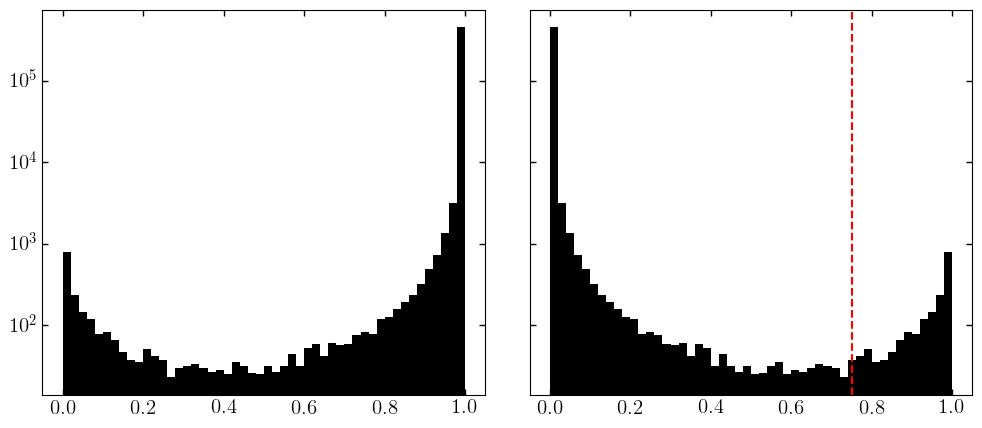

In [349]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=50)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=50)
ax2.set_yscale('log')
ax2.axvline(0.75, c='r', ls='--')

plt.show()

In [350]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.75)
memb_sel3 = np.array(memb_prob>0.9)

iso_obj.turnoff = 13.0
_ = iso_obj.simpleSln()
distmod_spl = np.poly1d([1/64**2, 100/64**2, (50/64)**2 +18.82-4.45])
dist_mod_shift = distmod_spl(all_data_["phi1"])

cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.3)
g_r = all_data_['g0'] - all_data_['r0']
Gmag = all_data['g0'] - dist_mod_shift

cmd_sel = np.array(cmd_patch.contains_points(np.array([g_r, Gmag]).T) | hb_patch.contains_points(np.array([g_r, Gmag]).T))

In [351]:
print(len(all_data_[memb_sel1]))
print(len(all_data_[memb_sel1&cmd_sel]))

2115
1568


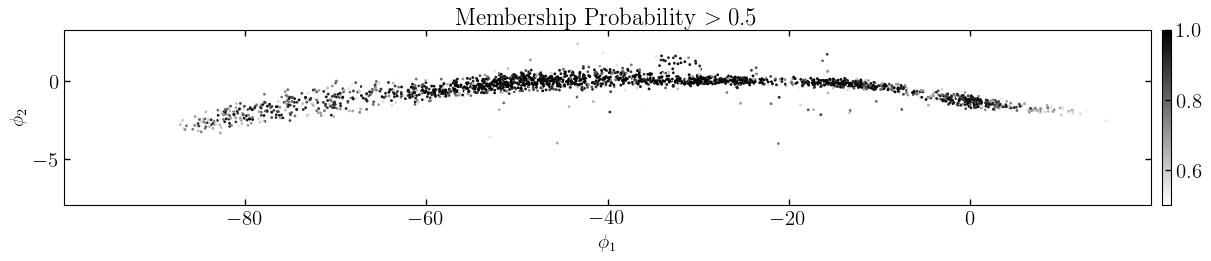

In [352]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

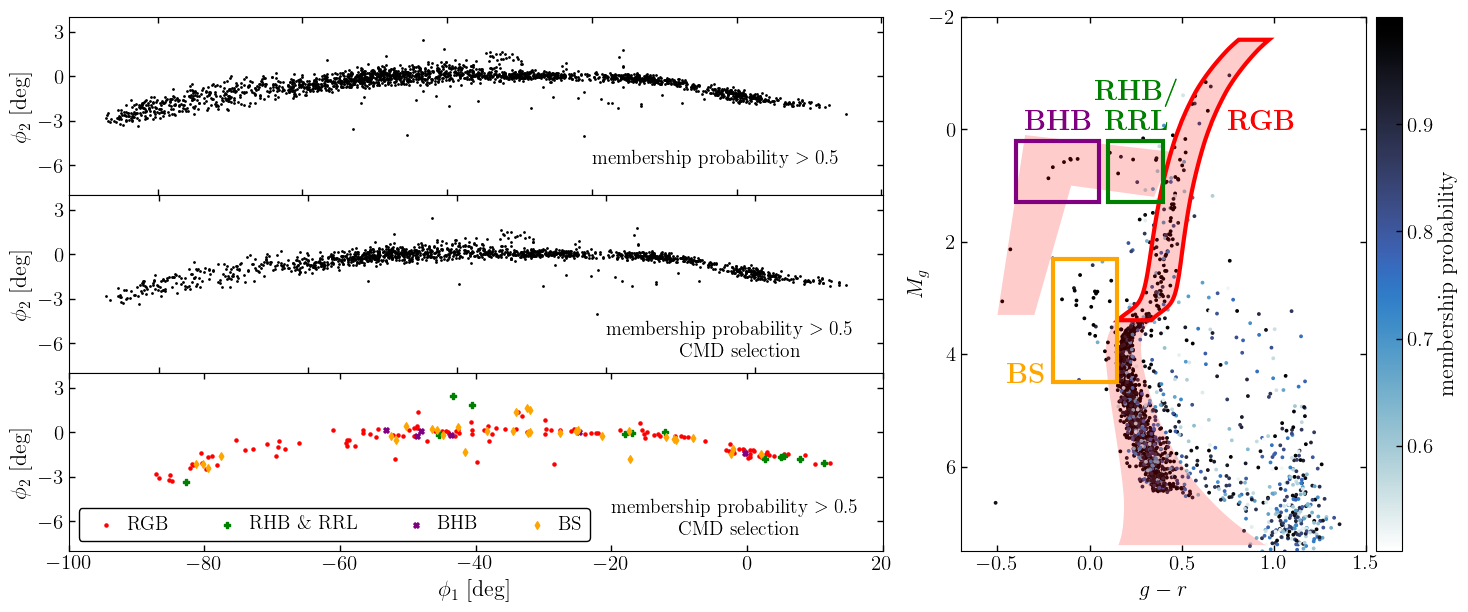

In [353]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_all = distmod_spl(all_data_[memb_sel1]["phi1"]) - iso_obj.dist_mod

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,6))
gs = GridSpec(6, 2, figure=fig, width_ratios=[1, 0.6], left=0.05, right=0.97, bottom=0.09, top=0.98, wspace=0.12)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0], sharey=ax1)
ax3 = fig.add_subplot(gs[4:6, 0], sharey=ax1)
ax4 = fig.add_subplot(gs[:, 1])

ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=1)
ax1.text(-20,-6, 'membership probability $> 0.5$', fontsize=14)
# ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xticklabels([])

# ax3.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=0.5, c='k', alpha=0.3)
ax2.scatter(all_data_[memb_sel1&cmd_sel]['phi1'], all_data_[memb_sel1&cmd_sel]['phi2'], s=1, c='k')
ax2.text(-20,-5.5, r'membership probability $> 0.5$', fontsize=14)
ax2.text(-10,-7, 'CMD selection', fontsize=14, color='k')

ax3.scatter(all_data_[memb_sel1&rgb_sel&(G<3.4)]['phi1'], all_data_[memb_sel1&rgb_sel&(G<3.4)]['phi2'], 
           c='r', marker='o', s=5, label='RGB')
ax3.scatter(all_data_[memb_sel1&rrl_sel]['phi1'], all_data_[memb_sel1&rrl_sel]['phi2'], 
           c='g', marker='P', s=15, label=r'RHB \&' + ' RRL')
ax3.scatter(all_data_[memb_sel1&bhb_sel]['phi1'], all_data_[memb_sel1&bhb_sel]['phi2'], 
           c='purple', marker='X', s=15, label='BHB')
ax3.scatter(all_data_[memb_sel1&bs_sel]['phi1'], all_data_[memb_sel1&bs_sel]['phi2'], 
           c='orange', marker='d', s=15, label='BS')
ax3.text(-20,-5.5, r'membership probability $> 0.5$', fontsize=14)
ax3.text(-10,-7, 'CMD selection', fontsize=14, color='k')
ax3.set_xlim(-100, 20)
ax3.set_ylim(-8,4)
ax3.set_yticks([-6,-3,0,3])
ax3.legend(ncols=4, loc='lower left', frameon=True, fancybox=True, edgecolor='k', framealpha=1, handletextpad=0.1)

im = ax4.scatter(all_data_[memb_sel1]['g0'] - all_data_[memb_sel1]['r0'], 
            all_data_[memb_sel1]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod,
            c = memb_prob[memb_sel1],
            cmap=cmr.arctic_r, s=3)
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)
rrl_patch = mpl.patches.Polygon(jnp.array([[0.1,1.3], [0.1,0.2], [0.4,0.2], [0.4,1.3]]), edgecolor="green", facecolor='none', lw=3)
bhb_patch = mpl.patches.Polygon(jnp.array([[-0.4,1.3], [-0.4,0.2], [0.05,0.2], [0.05,1.3]]), edgecolor="purple", facecolor='none', lw=3)
bs_patch = mpl.patches.Polygon(jnp.array([[-0.2,4.5], [-0.2,2.3], [0.15,2.3], [0.15,4.5]]), edgecolor="orange", facecolor='none', lw=3)
rgb_poly = cmd_poly[np.array(cmd_poly[:,1]) < 3.4]
rgb_patch = mpl.patches.Polygon(rgb_poly, edgecolor='red', facecolor='none', lw=3)
ax4.add_patch(cmd_patch) ; ax4.add_patch(hb_patch) ; ax4.add_patch(rgb_patch)
ax4.add_patch(rrl_patch) ; ax4.add_patch(bhb_patch) ; ax4.add_patch(bs_patch)
ax4.text(0.03,0,r'\textbf{RHB/}' + '\n' + r'\textbf{RRL}', color='green', fontsize=20, ma='center')
ax4.text(-0.35,0,r'\textbf{BHB}', color='purple', fontsize=20)
ax4.text(-0.45,4.5,r'\textbf{BS}', color='orange', fontsize=20)
ax4.text(0.75,0,r'\textbf{RGB}', color='red', fontsize=20)
ax4.set_xlabel(r'$g-r$', fontsize=16)
ax4.set_ylabel(r'$M_g$', fontsize=16, labelpad=0)
ax4.set_xlim(-0.7, 1.5)
ax4.set_ylim(7.5, -2)
cbar = fig.colorbar(im, ax=ax4, pad=0.02)
cbar.set_label('membership probability', fontsize=16)

ax1.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
plt.subplots_adjust(hspace=0, wspace=0.15)
plt.savefig('../../paper_figures/high_prob_members.pdf')
plt.savefig('../../paper_figures/high_prob_members.png')
plt.show()

In [354]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_all = distmod_spl(all_data_["phi1"]) - iso_obj.dist_mod

g = all_data_['g0'] ; r = all_data_['r0']
G = g - dist_mod_correct_all  - iso_obj.dist_mod

rrl_path = mpl.path.Path(jnp.array([[0.1,1.3], [0.1,0.2], [0.4,0.2], [0.4,1.3]]))
bhb_path = mpl.path.Path(jnp.array([[-0.4,1.3], [-0.4,0.2], [0.05,0.2], [0.05,1.3]]))
bs_path = mpl.path.Path(jnp.array([[0.15,2.3], [0.15,4.5], [-0.2,4.5], [-0.2,2.3], [0.15,2.3]]))
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_path = mpl.path.Path(cmd_poly)

rrl_sel = rrl_path.contains_points(np.array([g-r, G]).T)
bhb_sel = bhb_path.contains_points(np.array([g-r, G]).T)
bs_sel = bs_path.contains_points(np.array([g-r, G]).T)
rgb_sel = cmd_path.contains_points(np.array([g-r, G]).T)

In [71]:
mpl.rcParams['patch.linewidth'] = 1

In [355]:
all_data_['pass_CMD_cut'] = cmd_sel
all_data_['memb_prob'] = memb_prob
all_data_

<Table length=466571>
     source_id              ra         ... pass_CMD_cut        memb_prob       
                                       ...                                     
       int64             float64       ...     bool             float64        
------------------- ------------------ ... ------------ -----------------------
 576748068435698048 134.13841688083966 ...         True 1.1225615419098909e-173
 576748244530543488 134.16732705372561 ...        False  9.887020222489371e-122
 576750301818727936 134.22981963824748 ...        False   4.544968918645004e-07
 576760064280542592 134.14547166643905 ...        False 2.6573260687590614e-110
 576760300502579328  134.1113034294974 ...         True   4.410424522769622e-89
 576760334862325504 134.12016082647645 ...        False  2.5431788928909185e-07
 576760437941539712  134.1564021078413 ...        False  2.9673952677433554e-30
 576760884618149248 134.16590122401283 ...        False   7.161128796621286e-34
 576761262575264896 134.04034521551716 ...        False 8.1122868259812245e-137
                ...                ... ...          ...                     ...
5763858171501338752 132.35958296457127 ...        False   5.219005732873217e-11
5763858416314087936  132.4222150913482 ...         True   5.290026854737286e-29
5763859442811671936  132.3831513160118 ...        False  5.7276629623080274e-05
5763864734211393664 132.43933225841755 ...        False  1.2006008696773477e-83
5763865460060452224 132.39955636942776 ...        False  3.3404278703492545e-45
5763865734938359552 132.38369519625394 ...        False   6.393106701738995e-21
5763865902442504064  132.4447438143082 ...        False  8.097003271000196e-101
5763866246039894400 132.41030567238795 ...        False   4.173912737703681e-06
5763868582502122624 132.53086892838647 ...        False   4.314243260487082e-50

In [389]:
paper_tbl = all_data_['source_id','phi1','phi2','memb_prob','pass_CMD_cut']
paper_tbl.write('../../data/paper_table.fits', overwrite=True)

In [392]:
from astropy.io import ascii
ascii.write(paper_tbl[:10], format="latex", col_align='|lr|',
            latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*'})

\begin{table*}
\begin{center}
\begin{tabular}{|lr|}
source_id & phi1 & phi2 & memb_prob & pass_CMD_cut \\
 & $\mathrm{{}^{\circ}}$ & $\mathrm{{}^{\circ}}$ &  &  \\
576748068435698048 & -77.47744548223773 & -7.900720690605846 & 1.1225615419098909e-173 & True \\
576748244530543488 & -77.44140251696837 & -7.913403723893333 & 9.887020222489371e-122 & False \\
576750301818727936 & -77.3557635158985 & -7.936359587581789 & 4.544968918645004e-07 & False \\
576760064280542592 & -77.42744965924754 & -7.880088954961589 & 2.6573260687590614e-110 & False \\
576760300502579328 & -77.44766246689005 & -7.85221053515438 & 4.410424522769622e-89 & True \\
576760334862325504 & -77.42768814993843 & -7.850950654364558 & 2.5431788928909185e-07 & False \\
576760437941539712 & -77.41280142397284 & -7.884294484524052 & 2.9673952677433554e-30 & False \\
576760884618149248 & -77.37767954136586 & -7.875049093602 & 7.161128796621286e-34 & False \\
576761262575264896 & -77.46066548465501 & -7.777629929446274 & 8.112

In [83]:
all_data_.write('../../data/gd1_tbl_with_memb_prob.fits', overwrite=True)

#### Check blob and spur proper motions

In [84]:
# old_tbl_ = at.Table.read('../../data/gd1_tbl_with_memb_prob.fits')
old_tbl = all_data_[(all_data_['memb_prob'] > 0.5) & all_data_['pass_CMD_cut']]

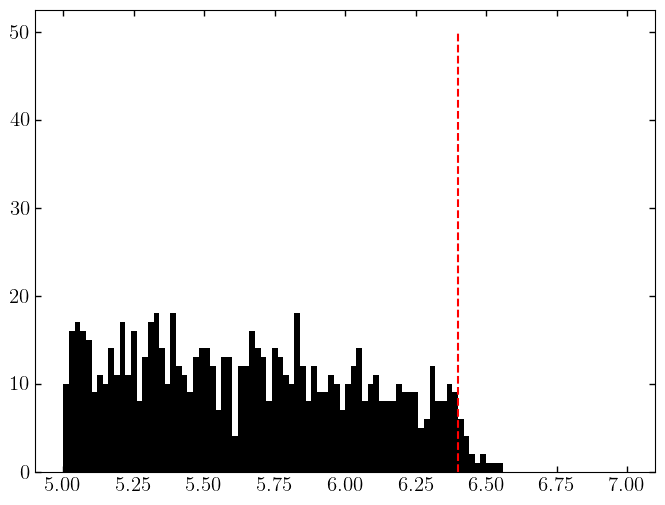

In [85]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_test = distmod_spl(old_tbl["phi1"]) - 14.59539

plt.hist(np.array(old_tbl['g0'] - dist_mod_correct_test  - 14.59539), bins=100, range=[5,7])
plt.vlines(6.4, 0, 50, color='r', ls='--')
plt.show()

In [86]:
blob_region = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-13)]
blob = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-10) & ((old_tbl['phi2']<-0.50) | (old_tbl['phi2']>0.30))]

spur_region = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-25)]
spur = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-25) & (old_tbl['phi2']>0.5)]

In [87]:
len(spur)

57

In [88]:
len(spur_region)

336

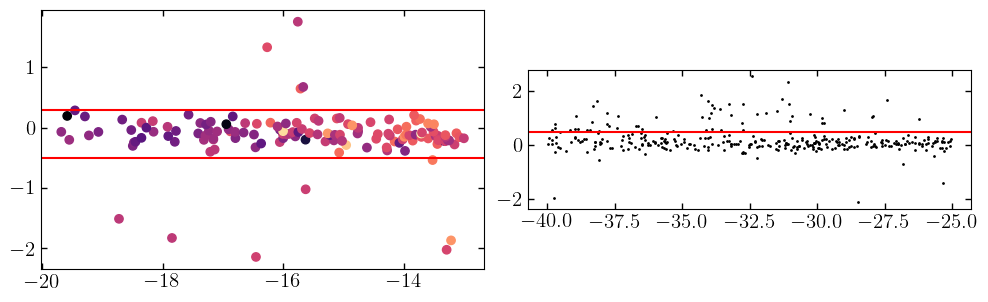

In [89]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))
ax1.scatter(blob_region['phi1'], blob_region['phi2'], c=blob_region['pm1'])
ax1.axhline(-0.50, color='r')
ax1.axhline(0.30, color='r')
ax1.set_aspect('equal')

ax2.scatter(spur_region['phi1'], spur_region['phi2'], c='k', s=1)
ax2.axhline(0.5, color='r')
ax2.set_aspect('equal')
plt.show()

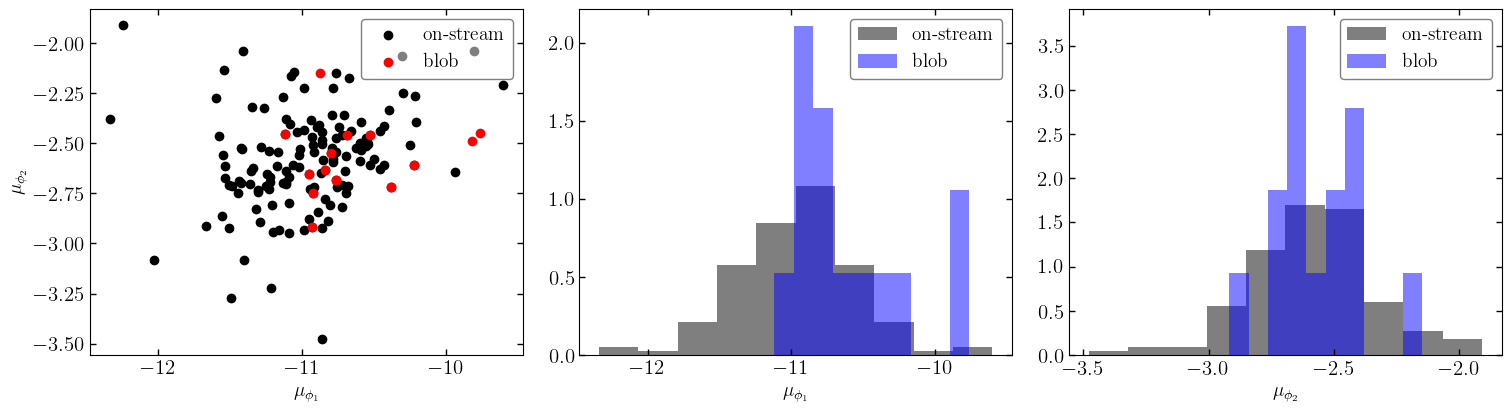

In [90]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(blob_region['pm1'], blob_region['pm2'], c='k', label='on-stream')
ax1.scatter(blob['pm1'], blob['pm2'], c='r', label='blob')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k')

ax2.hist(blob_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(blob['pm1'], density=True, alpha=0.5, label='blob')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(blob_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(blob['pm2'], density=True, alpha=0.5, label='blob')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

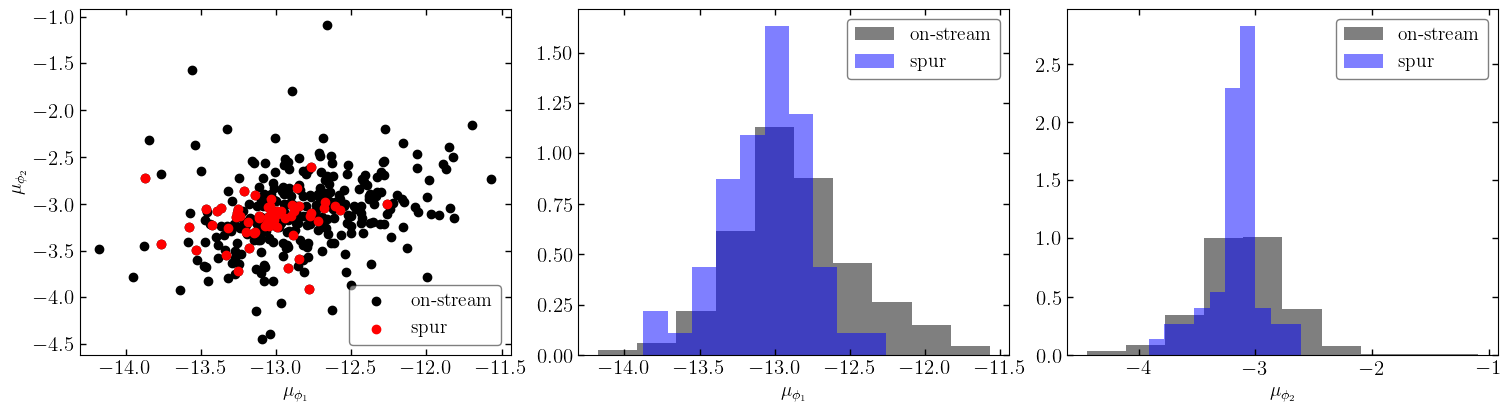

In [91]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(spur_region['pm1'], spur_region['pm2'], c='k', label='on-stream')
ax1.scatter(spur['pm1'], spur['pm2'], c='r', label='spur')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k', loc='lower right')

ax2.hist(spur_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(spur['pm1'], density=True, alpha=0.5, label='spur')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(spur_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(spur['pm2'], density=True, alpha=0.5, label='spur')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

#### Blob/Spur Offset from Model

In [562]:
((offtrack_pm1_mean - stream_pm1_mean) * u.mas/u.yr).to(u.rad/u.s) * (10**((distmod_spl(blob_loc)+5) / 5)*u.pc).to(u.km)

<Quantity 9.05132114 km rad / s>

In [564]:
(offtrack_pm1_mean - stream_pm1_mean) / stream_pm1_scale

np.float64(2.191940978085427)

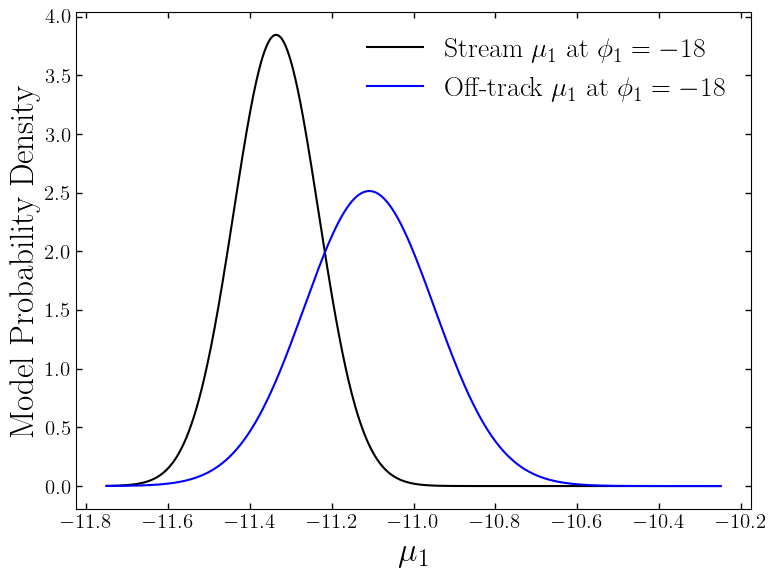

In [558]:
x = np.linspace(-11.75,-10.25, 1000)
blob_loc = -18
stream_pm1_mean, stream_pm1_scale = stream_pm1_track(blob_loc), stream_pm1_width(blob_loc)
offtrack_pm1_mean, offtrack_pm1_scale = offtrack_pm1_track(blob_loc), offtrack_pm1_width(blob_loc)

# Compute the probability density function (PDF)
streampdf = scipy.stats.norm.pdf(x, loc=stream_pm1_mean, scale=stream_pm1_scale, )
offtrackpdf = scipy.stats.norm.pdf(x, loc=offtrack_pm1_mean, scale=offtrack_pm1_scale)

# Plot the Gaussian
plt.figure(figsize=(8, 6))
plt.plot(x, streampdf, label=r'Stream $\mu_1$ at $\phi_1=-18$')
plt.plot(x, offtrackpdf, label=r'Off-track  $\mu_1$ at $\phi_1=-18$')
plt.xlabel(r"$\mu_1$", fontsize=24)
plt.ylabel("Model Probability Density", fontsize=24)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('../../paper_figures/blob_pm1_model_pdf.pdf')
plt.show()

In [92]:
# Generate a sample instead of using MAP_svi_results.params because that is being weird for some reason in the offtrack pms
pred_dist = Predictive(guide, params=svi_results.params, num_samples=100)
pars_ = pred_dist(jax.random.PRNGKey(42), data=run_data)

In [93]:
pars_['stream:pm1:scale_vals'][0]

Array([0.92233803, 0.3801891 , 0.21293898, 0.16378807, 0.1640099 ,
       0.11493795, 0.09537833, 0.09105227, 0.10913092, 0.1065263 ,
       0.17814952, 0.41454723, 0.47225386], dtype=float64)

Text(0.5, 0, '$\\phi_1$ [deg]')

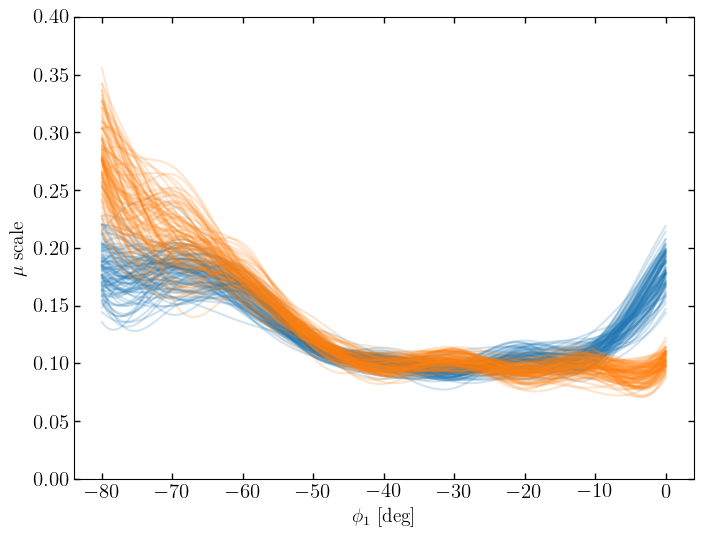

In [97]:
xgrid = np.linspace(-80, 0, 256)

for name, color in zip(["pm1", "pm2"], ["tab:blue", "tab:orange", "tab:green"]):
    spl_grid = np.zeros((pars_[f'stream:{name}:scale_vals'].shape[0], len(xgrid)))
    for i in range(pars_[f'stream:{name}:scale_vals'].shape[0]):
        spl = IUS(stream_model.coord_parameters[name]['knots'], pars_[f'stream:{name}:scale_vals'][i], k=3)
        spl_grid[i] = spl(xgrid)
    plt.plot(xgrid, spl_grid.T, alpha=0.2, color=color);
plt.ylim(0,0.4)
plt.ylabel(r'$\mu$ scale')
plt.xlabel(r'$\phi_1$ [deg]')

In [98]:
phi1_spur = -32
phi1_blob = -16

stream_pm1_mean_cubic_spline = IUS(stream_model.coord_parameters['pm1']['knots'], jnp.mean(pars_['stream:pm1:loc_vals'], axis=0), k=3)
stream_pm1_scale_cubic_spline = IUS(stream_model.coord_parameters['pm1']['knots'], jnp.mean(pars_['stream:pm1:scale_vals'], axis=0), k=3)
stream_pm2_mean_cubic_spline = IUS(stream_model.coord_parameters['pm2']['knots'], jnp.mean(pars_['stream:pm2:loc_vals'], axis=0), k=3)
stream_pm2_scale_cubic_spline = IUS(stream_model.coord_parameters['pm2']['knots'], jnp.mean(pars_['stream:pm2:scale_vals'], axis=0), k=3)
stream_rv_mean_cubic_spline = IUS(stream_model.coord_parameters['rv']['knots'], jnp.mean(pars_['stream:rv:loc_vals'], axis=0), k=3)
stream_rv_scale_cubic_spline = IUS(stream_model.coord_parameters['rv']['knots'], jnp.mean(pars_['stream:rv:scale_vals'], axis=0), k=3)


offtrack_pm1_mean_cubic_spline = IUS(stream_model.coord_parameters['pm1']['knots'], jnp.mean(pars_['offtrack:pm1:loc_vals'], axis=0), k=3)
offtrack_pm1_scale_cubic_spline = IUS(stream_model.coord_parameters['pm1']['knots'], jnp.mean(pars_['offtrack:pm1:scale_vals'], axis=0), k=3)
offtrack_pm2_mean_cubic_spline = IUS(stream_model.coord_parameters['pm2']['knots'], jnp.mean(pars_['offtrack:pm2:loc_vals'], axis=0), k=3)
offtrack_pm2_scale_cubic_spline = IUS(stream_model.coord_parameters['pm2']['knots'], jnp.mean(pars_['offtrack:pm2:scale_vals'], axis=0), k=3)
offtrack_rv_mean_cubic_spline = IUS(stream_model.coord_parameters['rv']['knots'], jnp.mean(pars_['offtrack:rv:loc_vals'], axis=0), k=3)
offtrack_rv_scale_cubic_spline = IUS(stream_model.coord_parameters['rv']['knots'], jnp.mean(pars_['offtrack:rv:scale_vals'], axis=0), k=3)

print('Spur')
print(r'Stream $\mu_{\phi_1}$:', stream_pm1_mean_cubic_spline(phi1_spur), stream_pm1_scale_cubic_spline(phi1_spur))
print(r'Offtrack $\mu_{\phi_1}$:', offtrack_pm1_mean_cubic_spline(phi1_spur), offtrack_pm1_scale_cubic_spline(phi1_spur))
print(r'Stream $\mu_{\phi_2}$:', stream_pm2_mean_cubic_spline(phi1_spur), stream_pm2_scale_cubic_spline(phi1_spur))
print(r'Offtrack $\mu_{\phi_2}$:', offtrack_pm2_mean_cubic_spline(phi1_spur), offtrack_pm2_scale_cubic_spline(phi1_spur))
print(r'Stream $v_r$:', stream_rv_mean_cubic_spline(phi1_spur), stream_rv_scale_cubic_spline(phi1_spur))
print(r'Offtrack $v_r$:', offtrack_rv_mean_cubic_spline(phi1_spur), offtrack_rv_scale_cubic_spline(phi1_spur))
print('')

print('blob')
print(r'Stream $\mu_{\phi_1}$:', stream_pm1_mean_cubic_spline(phi1_blob), stream_pm1_scale_cubic_spline(phi1_blob))
print(r'Offtrack $\mu_{\phi_1}$:', offtrack_pm1_mean_cubic_spline(phi1_blob), offtrack_pm1_scale_cubic_spline(phi1_blob))
print(r'Stream $\mu_{\phi_2}$:', stream_pm2_mean_cubic_spline(phi1_blob), stream_pm2_scale_cubic_spline(phi1_blob))
print(r'Offtrack $\mu_{\phi_2}$:', offtrack_pm2_mean_cubic_spline(phi1_blob), offtrack_pm2_scale_cubic_spline(phi1_blob))
print(r'Stream $v_r$:', stream_rv_mean_cubic_spline(phi1_blob), stream_rv_scale_cubic_spline(phi1_blob))
print(r'Offtrack $v_r$:', offtrack_rv_mean_cubic_spline(phi1_blob), offtrack_rv_scale_cubic_spline(phi1_blob))

Spur
Stream $\mu_{\phi_1}$: -12.896321479083364 0.09420210936166662
Offtrack $\mu_{\phi_1}$: -12.94540833775941 0.11859380784209309
Stream $\mu_{\phi_2}$: -3.118114189594952 0.10257558970836748
Offtrack $\mu_{\phi_2}$: -3.0863700996220826 0.11527363193375506
Stream $v_r$: -70.81605414280114 4.715506742400353
Offtrack $v_r$: -73.09206409757076 5.333367177430595

blob
Stream $\mu_{\phi_1}$: -11.043305221828701 0.10260090561477855
Offtrack $\mu_{\phi_1}$: -10.843638246971842 0.16928283554242285
Stream $\mu_{\phi_2}$: -2.597011047616814 0.09546071429889957
Offtrack $\mu_{\phi_2}$: -2.5870343062486687 0.11152396881384573
Stream $v_r$: -173.71527308202016 4.90878391485535
Offtrack $v_r$: -173.75633434948386 13.657607337586168


In [ ]:
# Calculate 3D difference in velocity

### Plot RV members

In [99]:
len(all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)])

315

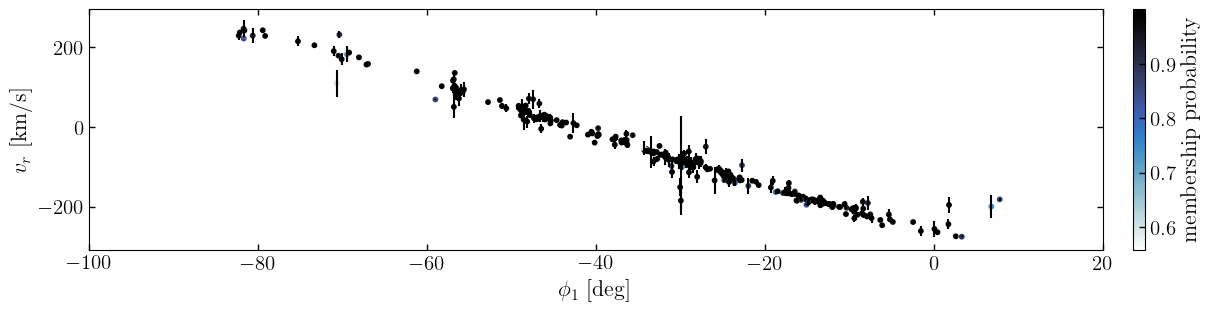

In [100]:
c_map='gray_r'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,3), layout="constrained")
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

# im1 = ax1.scatter(all_data_[memb_sel1&~memb_sel2&cmd_sel&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&~memb_sel2&cmd_sel&np.array(all_data_['rv']!=0)]['rv'], 
#                   c='r',
#                   s=10)

ax1.errorbar(all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)]['rv'], 
            yerr=all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)]['rv_err'],
            c='k', fmt='none')
im1 = ax1.scatter(all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)]['rv'], 
                  c=memb_prob[memb_sel1&cmd_sel&np.array(all_data_['rv']!=0)],
                  s=10, cmap=cmr.arctic_r, zorder=0)
ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=16)
ax1.set_ylabel(r"$v_r$ [km/s]", fontsize=16)
ax1.set_xlim(-100, 20)
# ax1.set_ylim(-500,500)
cbar = fig.colorbar(im1, ax=ax1, pad=0.02)
cbar.set_label('membership probability', fontsize=16)
plt.show()

In [515]:
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s*u.deg, phi2=phi2_track(phi1s)*u.deg, distance=10**((distmod_spl(phi1s)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s)*u.mas/u.yr, 
                radial_velocity=stream_rv_track(phi1s)*u.km/u.s)
galcen_coord_splines = gd1_coord_splines.transform_to(coord.Galactocentric())
ws = gd.PhaseSpacePosition(pos=galcen_coord_splines, vel=galcen_coord_splines.velocity)
energy = ws.energy(gp.Hamiltonian(gp.MilkyWayPotential2022()))

membs = all_data_[memb_sel1 & cmd_sel &(all_data_['rv']!=0)]
membs_coord = coord.ICRS(ra=np.array(membs['ra'])*u.deg, dec=np.array(membs['dec'])*u.deg, distance=10**((distmod_spl(membs['phi1'].value)+5) / 5)*u.pc,
                              pm_ra_cosdec=np.array(membs['pmra'])*u.mas/u.yr, pm_dec=np.array(membs['pmdec'])*u.mas/u.yr,
                              radial_velocity=np.array(membs['rv'])*u.km/u.s)
galcen_membs = membs_coord.transform_to(coord.Galactocentric())
ws_membs = gd.PhaseSpacePosition(pos=galcen_membs, vel=galcen_membs.velocity)
energy_membs = ws_membs.energy(gp.Hamiltonian(gp.MilkyWayPotential2022()))

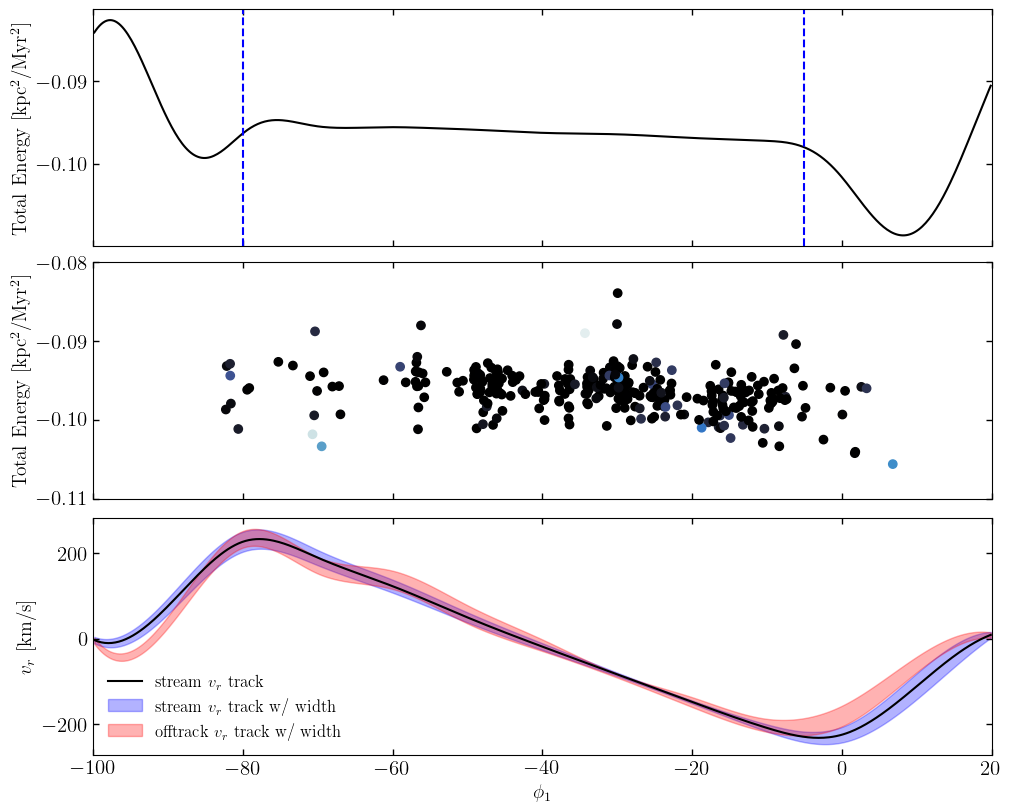

In [102]:
fig, [ax1, ax2, ax5] = plt.subplots(3,1, figsize=(10,8), sharex=True, constrained_layout=True)
ax1.plot(phi1s, energy)
ax1.axvline(-80, color='blue', ls='--');ax1.axvline(-5, color='blue', ls='--')
ax2.scatter(membs['phi1'], energy_membs, c=membs['memb_prob'], cmap=cmr.arctic_r)
ax2.set_ylim(-0.11, -0.08)
ax2.set_xlim(-100,20)

ax5.plot(phi1s, stream_rv_track(phi1s), c='k', label=r'stream $v_r$ track')
# ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, stream_rv_track(phi1s) - stream_rv_width(phi1s), stream_rv_track(phi1s) + stream_rv_width(phi1s), 
                 color='b', alpha=0.3, label=r'stream $v_r$ track w/ width')
ax5.fill_between(phi1s, offtrack_rv_track(phi1s) - offtrack_rv_width(phi1s), offtrack_rv_track(phi1s) + offtrack_rv_width(phi1s), 
                 color='r', alpha=0.3, label=r'offtrack $v_r$ track w/ width')
ax5.set_ylabel(r'$v_r$ [km/s]', fontsize=14)
ax5.legend(fontsize=12, loc='lower left')
ax5.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'Total Energy [kpc$^2$/Myr$^2$]')
ax2.set_ylabel(r'Total Energy [kpc$^2$/Myr$^2$]')

plt.show()

### Velocity Dispersion Along Stream

In [467]:
# Generate a sample instead of using MAP_svi_results.params because that is being weird for some reason in the offtrack pms
pred_dist = Predictive(guide, params=svi_results.params, num_samples=100)
pars_ = pred_dist(jax.random.PRNGKey(42), data=run_data)

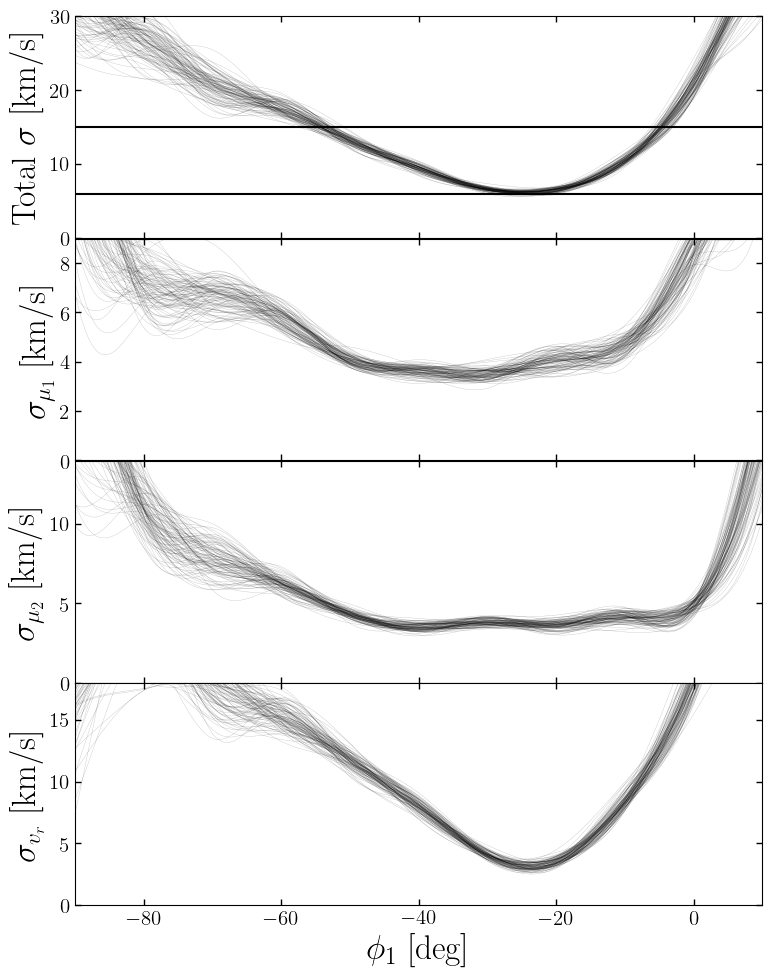

In [570]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
dist_pc = 10**((distmod_spl(phi1s)+5) / 5) * u.pc

spl_pm1_grid = np.zeros((pars_[f'stream:pm1:scale_vals'].shape[0], len(phi1s)))
spl_pm2_grid = np.zeros((pars_[f'stream:pm2:scale_vals'].shape[0], len(phi1s)))
spl_rv_grid = np.zeros((pars_[f'stream:rv:scale_vals'].shape[0], len(phi1s)))
spl_vel_disp_grid = np.zeros((pars_[f'stream:rv:scale_vals'].shape[0], len(phi1s)))

for i in range(pars_[f'stream:pm1:scale_vals'].shape[0]):
    spl_pm1 = IUS(stream_model.coord_parameters[name]['knots'], pars_['stream:pm1:scale_vals'][i], k=3)
    spl_pm2 = IUS(stream_model.coord_parameters[name]['knots'], pars_['stream:pm2:scale_vals'][i], k=3)
    spl_rv = IUS(stream_model.coord_parameters[name]['knots'], pars_['stream:rv:scale_vals'][i], k=3)
    spl_pm1_grid[i] = (spl_pm1(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km)
    spl_pm2_grid[i] = (spl_pm2(phi1s)  * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km)
    spl_rv_grid[i] = spl_rv(phi1s)*u.km/u.s
    spl_vel_disp_grid[i] = np.linalg.norm(np.array([spl_pm1_grid[i], spl_pm2_grid[i], spl_rv_grid[i]]), axis=0)

    
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1,figsize=(8,10), sharex=True)    
ax1.plot(phi1s, spl_vel_disp_grid.T, c='k', lw=0.25, alpha=0.25)
ax1.set_ylabel(r'Total $\sigma$ [km/s]', fontsize=24)
ax1.set_xlim(-90,10)
ax1.set_ylim(0,30)
# ax1.set_ylim(0,30)

ax2.plot(phi1s, spl_pm1_grid.T, c='k', lw=0.25, alpha=0.25)
ax2.set_ylabel(r' $\sigma_{\mu_1}$ [km/s]', fontsize=24)
ax2.set_ylim(0,9)

ax3.plot(phi1s, spl_pm2_grid.T, c='k', lw=0.25, alpha=0.25)
ax3.set_ylabel(r'$\sigma_{\mu_2}$ [km/s]', fontsize=24)
ax3.set_ylim(0,14)

ax4.plot(phi1s, spl_rv_grid.T, c='k', lw=0.25, alpha=0.25)
ax4.set_ylim(0,18)
ax4.set_ylabel(r'$\sigma_{v_r}$ [km/s]', fontsize=24)
ax4.set_xlabel(r'$\phi_1$ [deg]', fontsize=24)
# fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=-0.55)
# plt.savefig('../../paper_figures/vel_dispersion.pdf')
plt.show()

In [567]:
spl_vel_disp_grid.min()

np.float64(5.619520203927435)

#### Nibauer+24 method (do same for pms?)

In [104]:
(memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)).sum()

np.int64(295)

In [479]:
valluri_rv_phi1_knots = [-90, -70, -60,-46, -37.6, -29.2, -20.8, -15, -12.4, -4, 0, 20]
valluri_rvs = [79.79, 59.15, 27.61, -21.66, -46.38, -66.7, -93.19, -107.81, -113.29, -131.91, -144.31, -257.76]
valluri_rv_spl = IUS(valluri_rv_phi1_knots, valluri_rvs, k=3)

In [525]:
def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinates, to be
        transformed.
    v_sun : `~astropy.units.Quantity`, optional
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic())
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

In [550]:
gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s*u.deg, phi2=phi2_track(phi1s)*u.deg, distance=10**((distmod_spl(phi1s)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s)*u.mas/u.yr, 
                radial_velocity=stream_rv_track(phi1s)*u.km/u.s)
galcen_coord_splines = gd1_coord_splines.transform_to(coord.ICRS())

In [551]:
# gd1_frame_track = gc.GD1Koposov10(phi1=phi1s*u.deg, phi2=phi2_track(phi1s)*u.deg, distance=10**((distmod_spl(phi1s)+5) / 5)*u.pc,
#                 pm_phi1_cosphi2=stream_pm1_track(phi1s)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s)*u.mas/u.yr, 
#                 radial_velocity=stream_rv_track(phi1s)*u.km/u.s)
# icrs_track = gd1_frame_track.transform_to(coord.ICRS())
rv_track = rv_to_gsr(galcen_coord_splines)

Weighted standard deviation of residuals: 2.997237024813974


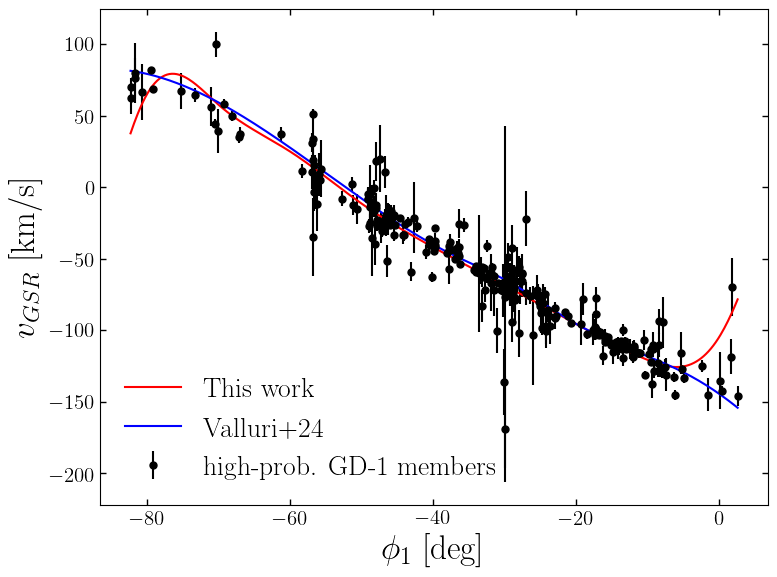

In [554]:
from scipy.optimize import curve_fit

# Define polynomial functions
def poly1(x, a, b):
    return a * x + b

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Choose fitting function
fit_func = poly1  # Try higher-degree polynomials if necessary

# Sample dataset with errors
x_data = all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['phi1']
y_data = all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['rv']
icrs = coord.SkyCoord(ra=all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['ra']*u.deg,
                      dec=all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['dec']*u.deg,
                      radial_velocity=all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['rv']*u.km/u.s,
                      frame='icrs')
rv_gsr = rv_to_gsr(icrs)
y_data = rv_gsr.value
y_errors = all_data_[memb_sel3 & cmd_sel & np.array(all_data_['rv'] != 0)]['rv_err']

# Fit the chosen polynomial to the data
params, cov = curve_fit(fit_func, x_data, y_data, sigma=y_errors, absolute_sigma=True)

# Generate fitted values and residuals
y_fitted = fit_func(x_data, *params)
residuals = y_data - y_fitted

# Compute weights and weighted statistics
weights = 1 / y_errors**2
weighted_mean_residuals = np.sum(weights * residuals) / np.sum(weights)
weighted_std_dev = np.sqrt(np.sum(weights * (residuals - weighted_mean_residuals)**2) / np.sum(weights))

# Compute reduced chi-square
reduced_chi_square = np.sum(((y_data - y_fitted) / y_errors) ** 2) / (len(y_data) - len(params))

# print("Fitted coefficients:", params)
print("Weighted standard deviation of residuals:", weighted_std_dev)
# print("Reduced chi-square:", reduced_chi_square)

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

# Top plot: Data with error bars and fitted polynomial
phi1s = np.linspace(min(x_data), max(x_data), 500)  # Smooth curve
ax1.errorbar(x_data, y_data, yerr=y_errors, fmt='o', color='black', ms=5, label='high-prob. GD-1 members')
# ax1.plot(phi1s, fit_func(phi1s, *params), color='red', label=r'$v_r = -$'+f'{-params[0]:.3f}'+r'$\,\phi_1\:-\:$'+f'{-params[1]:.3f}')
ax1.plot(phi1s, rv_track, color='red', label='This work')
plt.plot(phi1s, valluri_rv_spl(phi1s), color='blue', label='Valluri+24')
ax1.set_xlabel(r'$\phi_1$ [deg]', fontsize=24)
ax1.set_ylabel(r'$v_{GSR}$ [km/s]', fontsize=24)
ax1.legend(fontsize=20, loc='lower left')
# ax1.grid()

# # Bottom plot: Residuals with error bars
# ax2.errorbar(x_data, residuals, yerr=y_errors, fmt='o', color='green', label='Residuals with errors')
# ax2.axhline(0, color='black', linestyle='--', linewidth=1)
# ax2.set_xlabel('x')
# ax2.set_ylabel('Residuals')
# ax2.legend()
# ax2.grid()

plt.tight_layout()
plt.savefig('../../paper_figures/high_prob_rv_members.pdf')
plt.savefig('../../paper_figures/high_prob_rv_members.png')
plt.show()


In [404]:
params

array([  -6.48863331, -278.69352712])

In [403]:
reduced_chi_square

np.float64(13.765013357798434)

## Make Paper Plots

### Background Model

In [106]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
bkg_filename = svi_results_dir + 'bkg_{}_{}_{}_{}.pkl'.format(*bkg_knot_spacings)

with open(bkg_filename, 'rb') as input_file_:
    bkg_dict = pickle.load(input_file_)
    
bkg_svi_results = bkg_dict['svi_results']
bkg_guide = bkg_dict['guide']

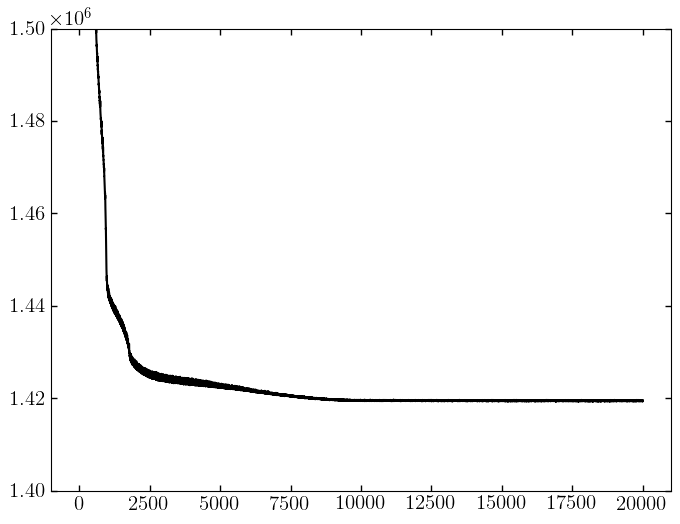

In [107]:
plt.plot(bkg_svi_results.losses)
plt.ylim(1.4e6, 1.5e6)
plt.show()

bkg_params = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                            guide=bkg_guide, num_samples=100, key=jax.random.PRNGKey(12345))

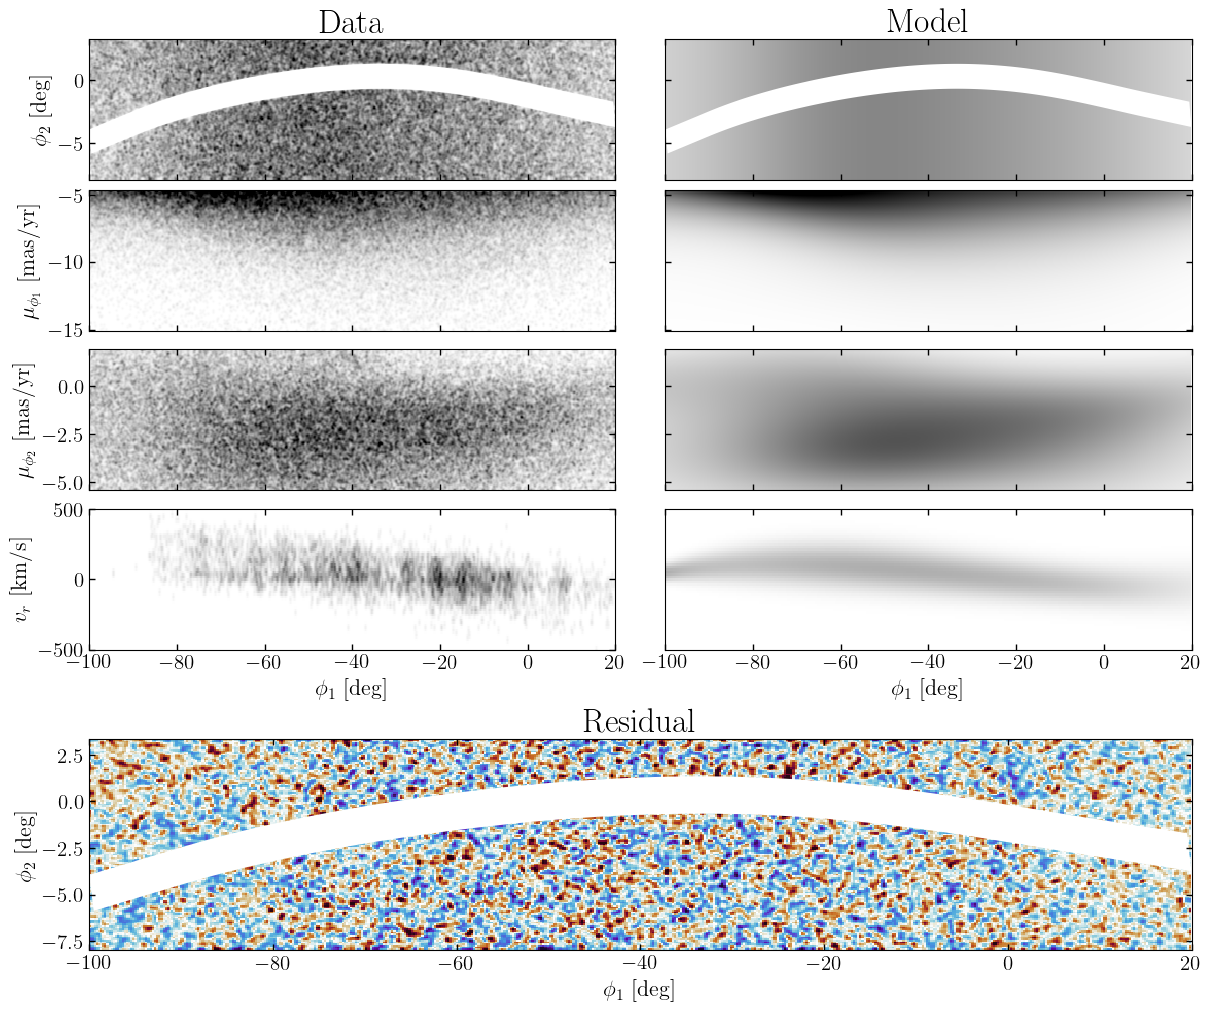

In [118]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_bkg_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

bkg_model.plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=bkg_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(bkg_data_['rv'][bkg_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=bkg_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=bkg_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

bkg_model.plot_residual_projections(
    grids=plot_grids, pars=bkg_params,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)


blank = cmr.take_cmap_colors(cmap, N=2, return_fmt='hex')[0]
for ax in [ax1,ax2,ax9]:
    patch_sky = mpl.patches.Polygon(
            iso_obj.pawprint.skyprint["stream"].vertices[::50],
            facecolor=blank,
            alpha=1
        )
    ax.add_patch(patch_sky)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-500,500)
ax8.set_xlim(-100,20)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

### Stream Model

In [119]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
stream_filename = svi_results_dir + 'stream_{}_{}_{}_{}_{}.pkl'.format(*stream_knot_spacings)

with open(stream_filename, 'rb') as input_file_:
    stream_dict = pickle.load(input_file_)
    
stream_svi_results = stream_dict['svi_results']
stream_guide = stream_dict['guide']

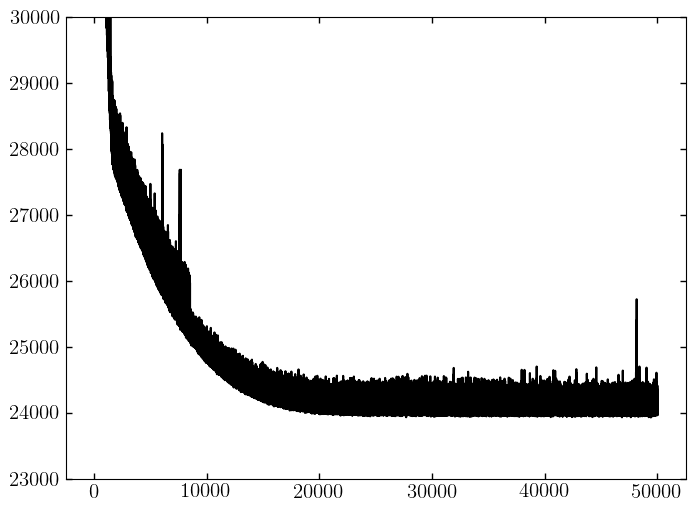

In [120]:
plt.plot(stream_svi_results.losses)
plt.ylim(23000, 30000)
plt.show()

stream_params = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                            guide=stream_guide, num_samples=1_000, key=jax.random.PRNGKey(12345))

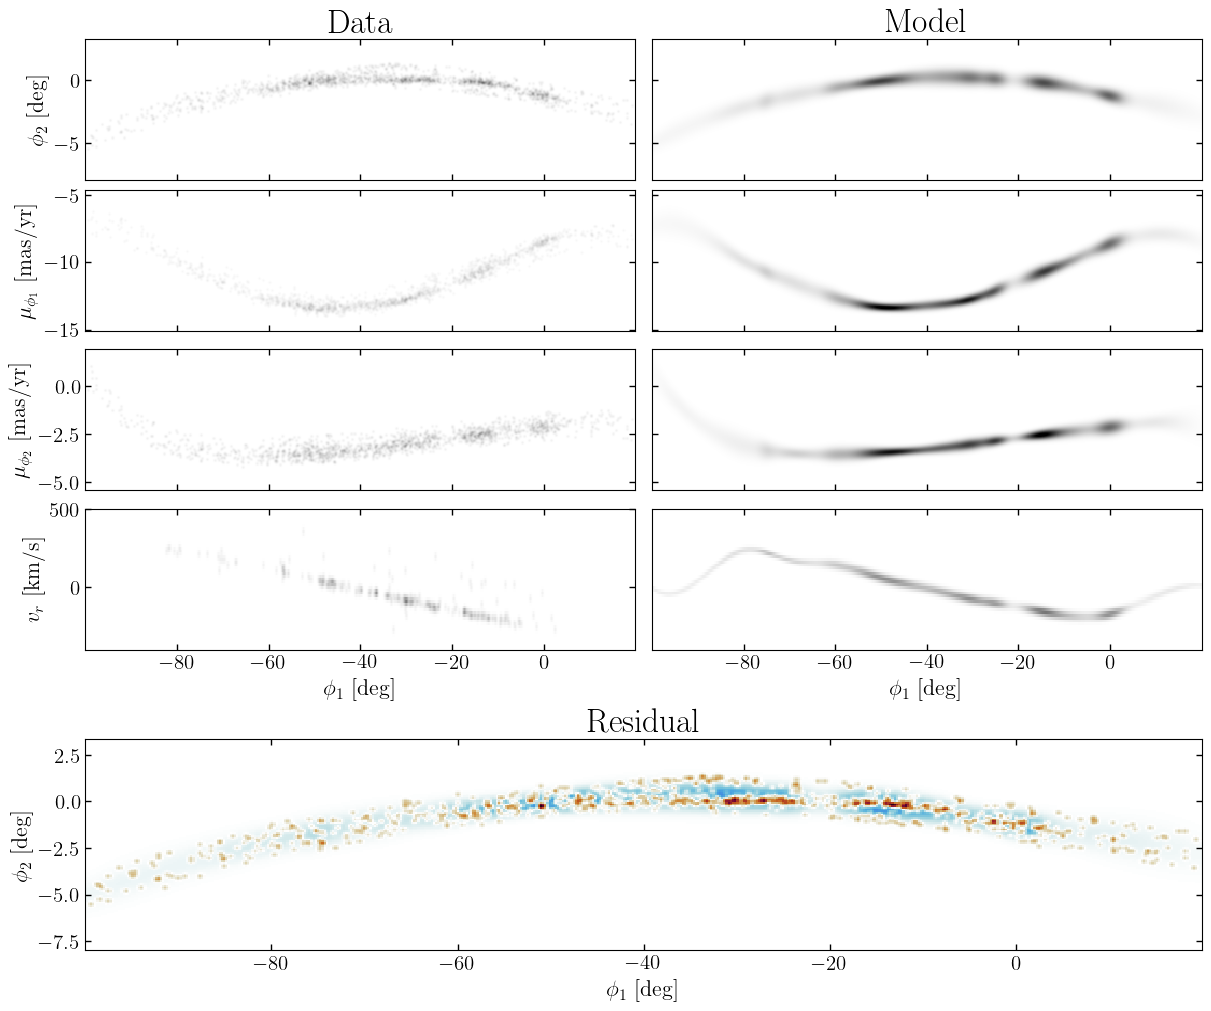

In [123]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_stream_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=stream_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
stream_model.plot_model_projections(ndata=len(stream_data_['rv'][stream_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=stream_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=stream_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))

stream_model.plot_residual_projections(
    grids=plot_grids, pars=stream_params,
    data=stream_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

# plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

## Random check on the side

In [204]:
new_plot_grids = {}
for key, val in plot_grids.items():
    new_plot_grids[key] = val[::2]

In [249]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

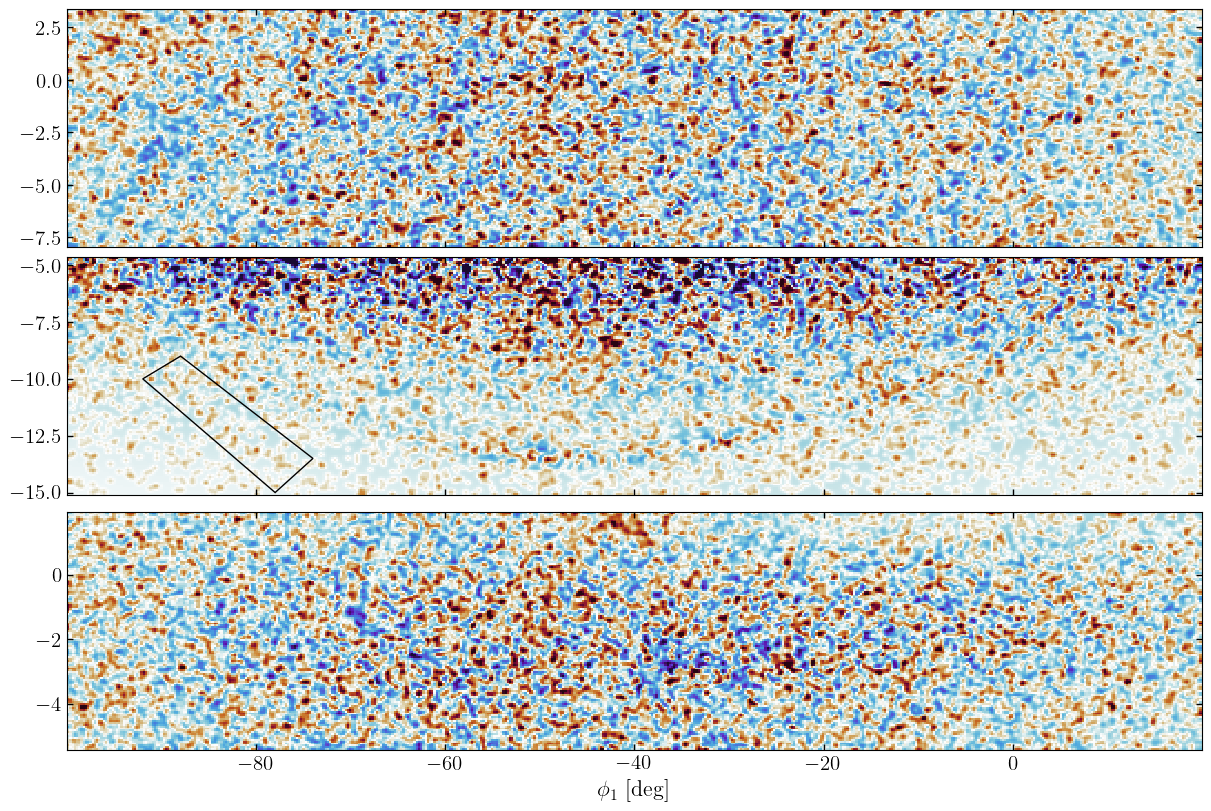

In [250]:
fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True, constrained_layout=True)
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=axs, label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion)
)
axs[1].add_patch(pm1_patch)
plt.show()

In [251]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

In [252]:
sel = pm1_patch.contains_points(jnp.array([run_data_['phi1'], run_data_['pm1']]).T)

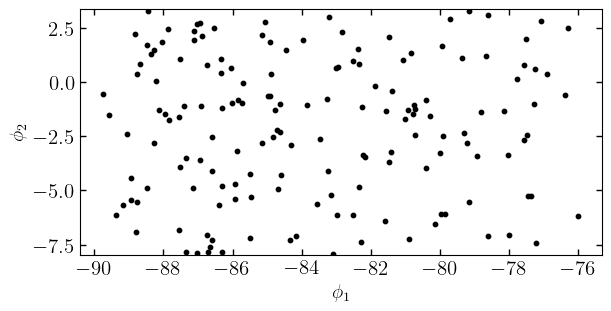

In [253]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['phi2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
plt.show()

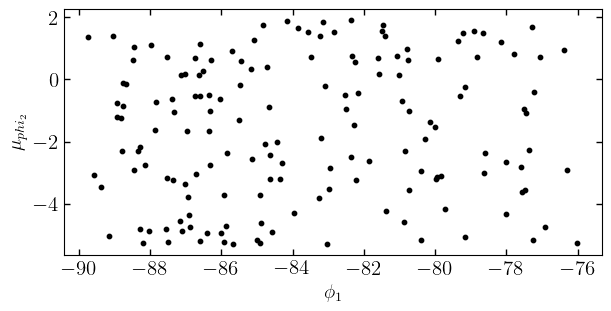

In [254]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['pm2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\mu_{phi_2}$')
plt.show()

### Visualizing different distance tracks

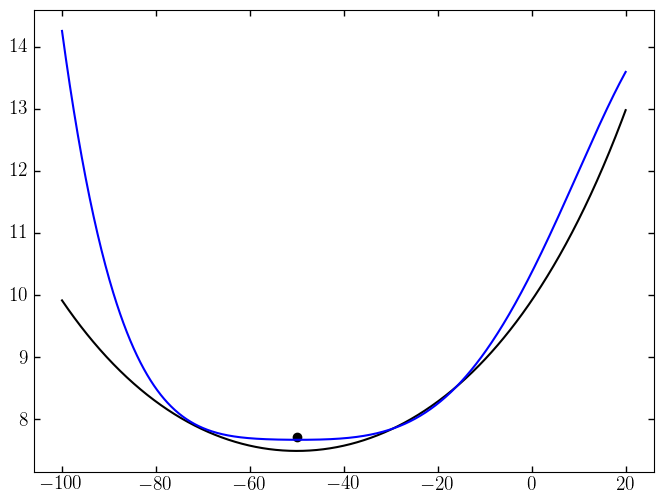

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
xs_deg = np.linspace(-100,20,1000)
xs_rad = np.deg2rad(xs_deg)

distmod_spl1 = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
distmod_spl2 = np.poly1d([-4.302, -11.54, -7.161, 5.985, 8.595, 10.36]) #Ibata+20 in radians

plt.plot(xs_deg, 0.001*10**((distmod_spl1(xs_deg)+5) / 5))
plt.plot(xs_deg, distmod_spl2(xs_rad))
plt.scatter(-50,7.7)
plt.show()

## Stellar mass calculation

In [124]:
import imf
#cite https://github.com/keflavich/imf

Should we use an IMF if we no longer have any more high mass stars?

In [125]:
kroupa = imf.Kroupa()

cutoff1 = 1

over1fraction = (kroupa.m_integrate(cutoff1, kroupa.mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0])

In [133]:
from isochrones.mist import MIST_Isochrone

mist = MIST_Isochrone()
iso = mist.isochrone(
    age=np.log10(1e9 * 12),  # has to be given in logAge
    feh=-2.5,
    eep_range=None,  # get the whole isochrone,
    distance=10,  # given in parsecs --> 10 ensures this is absolute magnitude which is a bitter tie to the way we cut our data
                  # could also just use the actual distance
)

initial_mass, actual_mass = iso.initial_mass.values, iso.mass.values
mag = iso.G_mag.values

In [134]:
np.mean(initial_mass[200:])

np.float64(0.8429368860491044)

In [135]:
m_min = IUS(np.flip(mag[:200]), np.flip(actual_mass[:200]))(5.9)
m_turnoff = IUS(np.flip(mag[:200]), np.flip(actual_mass[:200]))(3.5)
print(m_min, m_turnoff)

0.6344641660573375 0.8193468617146819


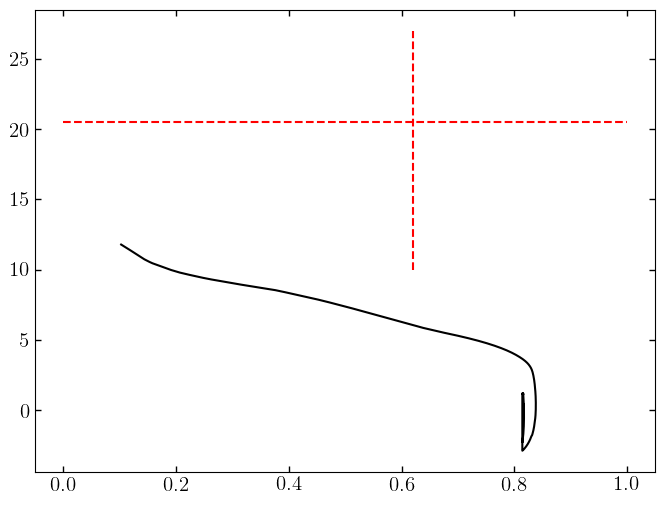

In [136]:
plt.plot(actual_mass, mag)
plt.hlines(20.5, 0,1, color='r', ls='--')
plt.vlines(0.61963443, 10,27, color='r', ls='--')
plt.show()

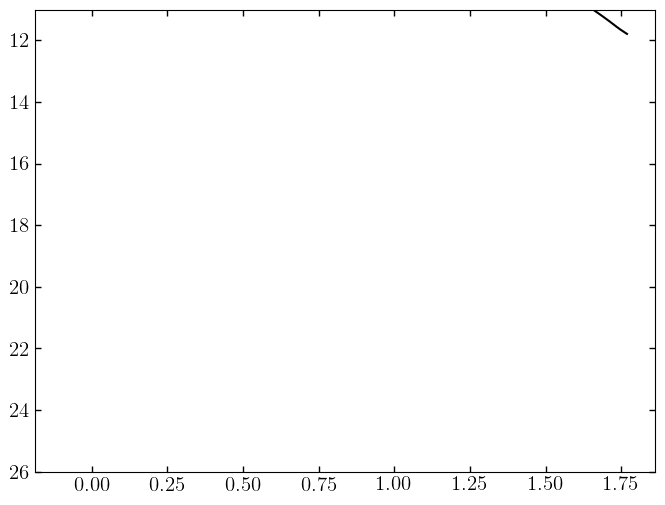

In [137]:
plt.plot(iso.BP_mag.values - iso.RP_mag.values, mag)
plt.ylim(26,11)
plt.show()

In [138]:
kroupa = imf.Kroupa()

In [139]:
# calculate the fraction of mass that is below our detection limit relative to the total initial mass
undet2mtot = kroupa.m_integrate(kroupa.mmin, m_min)[0] / kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0]
print(undet2mtot)

0.3618518184670608


35.6\% of the initial mass of the cluster is below the detection threshold. I need to figure out how much mass has been lost via stellar evolution.

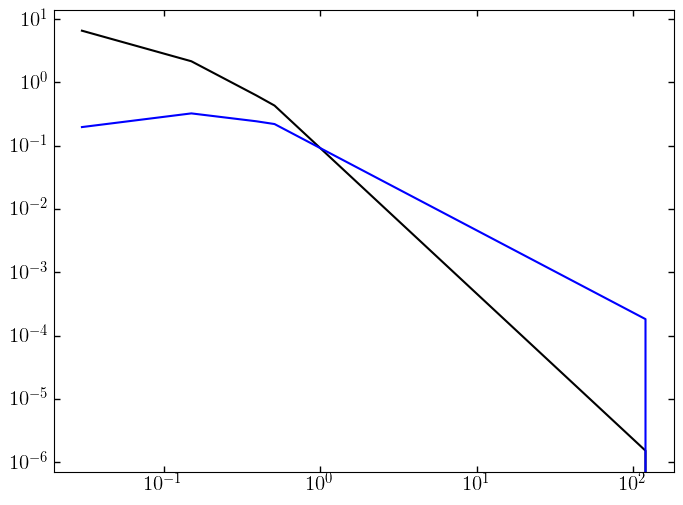

In [140]:
ms = np.linspace(kroupa.mmin, kroupa.mmax, 1000)

plt.loglog(ms, kroupa.dndm(ms))
plt.loglog(ms, kroupa.mass_weighted(ms))
plt.show()

In [141]:
n_ms_gd1 = len(all_data_[memb_sel1&cmd_sel&(all_data_['phot_g_mean_mag'] > 18)])
dn_ms = scipy.integrate.quad(kroupa.dndm, m_min, m_turnoff)[0]
norm_factor = n_ms_gd1/dn_ms
print(n_ms_gd1, norm_factor) #normalization factor is also equal to estimated number of stars in GD-1 at formation time

1377 38309.541794402445


In [142]:
n_undet = norm_factor * scipy.integrate.quad(kroupa.dndm, kroupa.mmin, m_min)[0]
print(n_undet)

33446.262460522754


In [143]:
detms2mtot = kroupa.m_integrate(m_min, m_turnoff)[0] / kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0]
print(detms2mtot)

0.059463958039113696


6.5\% of the mass is on the main sequence that we can see. There are 1430 detected stars in this area. Together, they have mass $\approx 1430\times0.7$. (feels like I'm going crazy not figuring out how to get that precisely

In [144]:
n_ms_gd1*0.7 / detms2mtot

np.float64(16209.819053181325)

So based on this I have $M_{ini} = 1.55\times10^4$ which is probably pretty accurate so maybe somehow this worked

In [145]:
undet2detms = kroupa.m_integrate(kroupa.mmin, m_min)[0] / kroupa.m_integrate(m_min, m_turnoff)[0]
print(undet2detms)

6.085229278364636


Also, there is 5.5 times as much mass in the undetected part as in the main sequence part so that is $\approx 1430*0.7*5.5 \approx 5500$ solar masses that are undetected

In [146]:
det_above_ms = len(all_data_[memb_sel1&cmd_sel]) - n_ms_gd1 +10 # add 10 for blue stragglers
print(det_above_ms)

229


Above the region I have queried, there are only $\sim 230$ additional stars (added a handful of blue stragglers and according to the MIST Isochrone they basically al have mass 0.8 $M_\odot$ so the current mass is $\approx 5500 + 230\times0.8$

In [147]:
undet2detms * n_ms_gd1*0.7 + det_above_ms * np.mean(initial_mass[200:])

np.float64(6058.585048320917)

In [247]:
undet2detms * n_ms_gd1*0.7

np.float64(5865.552501415672)

In [249]:
6058.585/1.621e4

0.3737560148056755